사용 가능한 한글 폰트: ['NanumSquare', 'NanumBarunGothic', 'NanumGothicCoding', 'NanumGothic', 'NanumMyeongjo', 'NanumSquareRound']
NanumGothic 폰트 발견: /usr/share/fonts/truetype/nanum/NanumGothic.ttf
✅ 한글 폰트 설정 완료: NanumGothic
현재 설정된 폰트: ['NanumGothic']


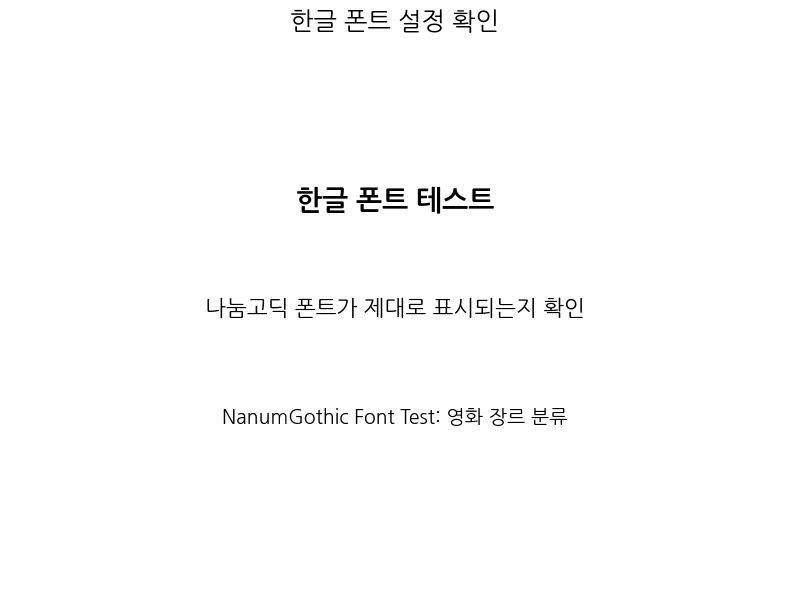

matplotlib 한글 폰트 설정이 완료되었습니다.


In [1]:
# matplotlib에서 한글 폰트 설정 (NanumGothic)
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os

# matplotlib 폰트 캐시 새로고침
fm._load_fontmanager(try_read_cache=False)

# 시스템에서 사용 가능한 한글 폰트 찾기
korean_fonts = []
for font in fm.fontManager.ttflist:
    if any(keyword in font.name for keyword in ['Korean', 'Nanum', 'Malgun', 'Dotum', 'Gulim']):
        korean_fonts.append(font.name)

# 중복 제거
korean_fonts = list(set(korean_fonts))
print("사용 가능한 한글 폰트:", korean_fonts)

# NanumGothic 폰트 경로 확인
nanum_paths = [
    '/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf',
    '/System/Library/Fonts/NanumGothic.ttc',
    '/Library/Fonts/NanumGothic.ttc'
]

nanum_available = False
for path in nanum_paths:
    if os.path.exists(path):
        print(f"NanumGothic 폰트 발견: {path}")
        nanum_available = True
        break

# 한글 폰트 설정 (우선순위별로 시도)
font_candidates = ['NanumGothic', 'NanumGothicOTF', 'Nanum Gothic', 'Malgun Gothic', 'DejaVu Sans']

font_set = False
for font_name in font_candidates:
    try:
        plt.rcParams['font.family'] = font_name
        # 테스트용 간단한 플롯으로 폰트 확인
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.text(0.5, 0.5, '한글 테스트: 나눔고딕', fontsize=16, ha='center', va='center')
        ax.set_title('한글 폰트 테스트')
        plt.close(fig)  # 실제로 표시하지 않고 닫기
        print(f"✅ 한글 폰트 설정 완료: {font_name}")
        font_set = True
        break
    except Exception as e:
        print(f"❌ {font_name} 설정 실패: {e}")
        continue

if not font_set:
    # 기본 폰트로 설정하고 마이너스 기호 문제 해결
    plt.rcParams['font.family'] = 'DejaVu Sans'
    print("⚠️ 한글 폰트를 찾을 수 없어 기본 폰트를 사용합니다.")

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 현재 설정된 폰트 확인
current_font = plt.rcParams['font.family']
print(f"현재 설정된 폰트: {current_font}")

# 한글 폰트 테스트
fig, ax = plt.subplots(figsize=(8, 6))
ax.text(0.5, 0.7, '한글 폰트 테스트', fontsize=20, ha='center', va='center', weight='bold')
ax.text(0.5, 0.5, '나눔고딕 폰트가 제대로 표시되는지 확인', fontsize=16, ha='center', va='center')
ax.text(0.5, 0.3, 'NanumGothic Font Test: 영화 장르 분류', fontsize=14, ha='center', va='center')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_title('한글 폰트 설정 확인', fontsize=18)
ax.axis('off')
plt.tight_layout()
plt.show()

print("matplotlib 한글 폰트 설정이 완료되었습니다.")

# 멀티모달 융합 기반 영화 장르 예측 모델 구현

이 노트북은 MM-IMDb 데이터셋을 활용하여 다양한 멀티모달 융합 기법으로 영화 장르를 예측하는 모델을 구현하고 성능을 비교 평가합니다.

## 주요 구현 내용
- 데이터 로딩 및 전처리: MM-IMDb 데이터셋 로딩, 이미지/텍스트 전처리
- 특징 추출 모델: ResNet50, ViT, BERT, RoBERTa
- 융합 전략: Early Fusion, Late Fusion, Attention Fusion, Cross-Attention Fusion
- 평가 지표: Accuracy, Precision, Recall, F1-score, ROC-AUC, mAP

## 1. 필요 라이브러리 임포트

In [2]:
# 기본 라이브러리
import os
import json
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# 이미지 처리
import cv2
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# 딥러닝 모델
import timm  # Vision Transformer용
from transformers import BertTokenizer, BertModel, RobertaTokenizer, RobertaModel

# 평가 지표
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, classification_report

# 시각화
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# 기타 유틸리티
import warnings
warnings.filterwarnings('ignore')

# 재현성 설정
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. 데이터 로딩 및 전처리

In [3]:
# 테스트 모드 설정 (빠른 실험을 위한 설정)
TEST_MODE = False  # True: 데이터 일부만 사용, False: 전체 데이터 사용
TEST_DATA_RATIO = 0.01  # 테스트 모드시 사용할 데이터 비율

# 데이터 경로 설정
DATA_ROOT = "/home/mingky/workspace/mmimdb_test/data/mmimdb"
DATASET_PATH = os.path.join(DATA_ROOT, "dataset")
SPLIT_PATH = os.path.join(DATA_ROOT, "split.json")

# 분할 정보 로드
with open(SPLIT_PATH, 'r') as f:
    splits = json.load(f)
    
train_ids = splits['train']
val_ids = splits['val'] if 'val' in splits else splits['dev'] 
test_ids = splits['test']

# 테스트 모드일 경우 데이터 일부만 사용
if TEST_MODE:
    import random
    random.seed(42)  # 재현성을 위한 시드 설정
    
    num_train = int(len(train_ids) * TEST_DATA_RATIO)
    num_val = int(len(val_ids) * TEST_DATA_RATIO)
    num_test = int(len(test_ids) * TEST_DATA_RATIO)
    
    train_ids = random.sample(train_ids, num_train)
    val_ids = random.sample(val_ids, num_val)
    test_ids = random.sample(test_ids, num_test)
    
    print(f"🧪 TEST MODE 활성화됨 (데이터의 {TEST_DATA_RATIO*100}%만 사용)")

print(f"Train set: {len(train_ids)} samples")
print(f"Validation set: {len(val_ids)} samples")
print(f"Test set: {len(test_ids)} samples")

Train set: 15552 samples
Validation set: 2608 samples
Test set: 7799 samples


In [4]:
# 모든 장르 목록 가져오기
def get_all_genres():
    all_genres = set()
    for file_id in train_ids:
        json_path = os.path.join(DATASET_PATH, f"{file_id}.json")
        if os.path.exists(json_path):
            with open(json_path, 'r') as f:
                movie_data = json.load(f)
                if 'genres' in movie_data:
                    all_genres.update(movie_data['genres'])
    
    return sorted(list(all_genres))

# 장르 목록
genre_list = get_all_genres()
genre_to_idx = {genre: idx for idx, genre in enumerate(genre_list)}
idx_to_genre = {idx: genre for idx, genre in enumerate(genre_list)}

print(f"Total number of genres: {len(genre_list)}")
print(f"Genres: {genre_list}")

Total number of genres: 26
Genres: ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']


In [5]:
# MM-IMDb 데이터셋 클래스 정의
class MMIMDbDataset(Dataset):
    def __init__(self, movie_ids, dataset_path, genre_to_idx, 
                 img_transform=None, text_tokenizer=None, max_length=512):
        self.movie_ids = movie_ids
        self.dataset_path = dataset_path
        self.genre_to_idx = genre_to_idx
        self.img_transform = img_transform
        self.text_tokenizer = text_tokenizer
        self.max_length = max_length
        self.num_labels = len(genre_to_idx)
        
        # 유효한 ID만 필터링 (이미지와 JSON 파일이 모두 있는 경우)
        self.valid_ids = []
        for movie_id in tqdm(movie_ids, desc="Validating dataset"):
            img_path = os.path.join(dataset_path, f"{movie_id}.jpeg")
            json_path = os.path.join(dataset_path, f"{movie_id}.json")
            
            if os.path.exists(img_path) and os.path.exists(json_path):
                self.valid_ids.append(movie_id)
        
        print(f"Found {len(self.valid_ids)} valid samples out of {len(movie_ids)}")
    
    def __len__(self):
        return len(self.valid_ids)
    
    def __getitem__(self, idx):
        movie_id = self.valid_ids[idx]
        img_path = os.path.join(self.dataset_path, f"{movie_id}.jpeg")
        json_path = os.path.join(self.dataset_path, f"{movie_id}.json")
        
        # 이미지 로드 및 전처리
        try:
            image = Image.open(img_path).convert('RGB')
            if self.img_transform:
                image = self.img_transform(image)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # 오류 발생 시 임의의 검은색 이미지 생성
            image = torch.zeros((3, 224, 224))
        
        # JSON 데이터 로드
        with open(json_path, 'r') as f:
            movie_data = json.load(f)
        
        # 텍스트 추출 및 전처리
        plot = " ".join(movie_data.get('plot', [""]))
        
        if self.text_tokenizer:
            text_encoding = self.text_tokenizer(
                plot,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            
            input_ids = text_encoding['input_ids'].squeeze()
            attention_mask = text_encoding['attention_mask'].squeeze()
            text_inputs = {
                'input_ids': input_ids,
                'attention_mask': attention_mask
            }
        else:
            text_inputs = plot
        
        # 장르 라벨 생성 (원-핫 인코딩)
        genres = movie_data.get('genres', [])
        labels = torch.zeros(self.num_labels)
        for genre in genres:
            if genre in self.genre_to_idx:
                labels[self.genre_to_idx[genre]] = 1.0
        
        return {
            'image': image,
            'text': text_inputs,
            'labels': labels,
            'movie_id': movie_id,
            'plot': plot
        }

In [6]:
# 이미지 변환 정의
image_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# 텍스트 토크나이저 설정
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# 데이터셋 생성 (BERT 토크나이저 사용)
train_dataset = MMIMDbDataset(
    train_ids, DATASET_PATH, genre_to_idx, 
    img_transform=image_transforms['train'], 
    text_tokenizer=bert_tokenizer
)

val_dataset = MMIMDbDataset(
    val_ids, DATASET_PATH, genre_to_idx, 
    img_transform=image_transforms['val'], 
    text_tokenizer=bert_tokenizer
)

test_dataset = MMIMDbDataset(
    test_ids, DATASET_PATH, genre_to_idx, 
    img_transform=image_transforms['test'], 
    text_tokenizer=bert_tokenizer
)

# 데이터 로더 설정
batch_size = 16

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
)

test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
)

Validating dataset:   0%|          | 0/15552 [00:00<?, ?it/s]

Found 15552 valid samples out of 15552


Validating dataset:   0%|          | 0/2608 [00:00<?, ?it/s]

Found 2608 valid samples out of 2608


Validating dataset:   0%|          | 0/7799 [00:00<?, ?it/s]

Found 7799 valid samples out of 7799


## 3. 모델 아키텍처 구현

### 3.1 특징 추출기 구현

In [7]:
# 이미지 특징 추출기
class ImageFeatureExtractor(nn.Module):
    def __init__(self, feature_extractor='resnet50', pretrained=True, freeze=True):
        super(ImageFeatureExtractor, self).__init__()
        self.feature_extractor = feature_extractor
        
        if feature_extractor == 'resnet50':
            self.model = models.resnet50(pretrained=pretrained)
            # 마지막 FC 레이어 제거
            self.model = nn.Sequential(*list(self.model.children())[:-1])
            self.feature_dim = 2048
        elif feature_extractor == 'vit':
            # ViT (Vision Transformer)
            self.model = timm.create_model('vit_base_patch16_224', pretrained=pretrained)
            self.feature_dim = self.model.head.in_features
            # 헤드 제거
            self.model.head = nn.Identity()
            
        # 특징 추출기 레이어 고정 (선택적)
        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False
                
    def forward(self, x):
        features = self.model(x)
        # Reshape: 배치 차원을 유지하면서 flatten
        if self.feature_extractor == 'resnet50':
            features = features.view(features.size(0), -1)
        return features

# 텍스트 특징 추출기
class TextFeatureExtractor(nn.Module):
    def __init__(self, feature_extractor='bert', pretrained=True, freeze=True):
        super(TextFeatureExtractor, self).__init__()
        self.feature_extractor = feature_extractor
        
        if feature_extractor == 'bert':
            self.model = BertModel.from_pretrained('bert-base-uncased')
            self.feature_dim = 768
        elif feature_extractor == 'roberta':
            self.model = RobertaModel.from_pretrained('roberta-base')
            self.feature_dim = 768
            
        # 특징 추출기 레이어 고정 (선택적)
        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False
                
    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        # [CLS] 토큰 임베딩 사용
        return outputs.last_hidden_state[:, 0, :]

### 3.2 융합 모듈 구현

In [8]:
# 1. Early Fusion (단순 연결)
class EarlyFusionModule(nn.Module):
    def __init__(self, img_feat_dim, text_feat_dim):
        super(EarlyFusionModule, self).__init__()
        self.fusion_dim = img_feat_dim + text_feat_dim
        
    def forward(self, img_features, text_features):
        # 단순히 두 특징 벡터를 연결
        fused_features = torch.cat([img_features, text_features], dim=1)
        return fused_features

# 2. Late Fusion (분류 결과 결합)
class LateFusionModule(nn.Module):
    def __init__(self, img_feat_dim, text_feat_dim, num_classes):
        super(LateFusionModule, self).__init__()
        self.fusion_dim = num_classes
        
        # 이미지 분류기
        self.img_classifier = nn.Sequential(
            nn.Linear(img_feat_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        
        # 텍스트 분류기
        self.text_classifier = nn.Sequential(
            nn.Linear(text_feat_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        
        # 가중치 학습 파라미터
        self.alpha = nn.Parameter(torch.FloatTensor([0.5]))
        
    def forward(self, img_features, text_features):
        # 각 모달리티별 예측
        img_preds = self.img_classifier(img_features)
        text_preds = self.text_classifier(text_features)
        
        # 가중치 결합
        alpha = torch.sigmoid(self.alpha)
        fused_preds = alpha * img_preds + (1 - alpha) * text_preds
        
        return fused_preds

# 3. Attention Fusion (모달리티 간 어텐션)
class AttentionFusionModule(nn.Module):
    def __init__(self, img_feat_dim, text_feat_dim):
        super(AttentionFusionModule, self).__init__()
        
        # 투영 차원
        self.proj_dim = 512
        
        # 특징 투영 레이어
        self.img_projection = nn.Linear(img_feat_dim, self.proj_dim)
        self.text_projection = nn.Linear(text_feat_dim, self.proj_dim)
        
        # 어텐션 레이어
        self.attention = nn.Sequential(
            nn.Linear(self.proj_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )
        
        self.fusion_dim = self.proj_dim
        
    def forward(self, img_features, text_features):
        # 특징 투영
        img_proj = self.img_projection(img_features)
        text_proj = self.text_projection(text_features)
        
        # 연결하여 어텐션 가중치 계산
        combined = torch.cat([img_proj, text_proj], dim=1)
        attention_weights = self.attention(combined)
        
        # 가중치 적용 및 결합
        fused_features = attention_weights[:, 0].unsqueeze(1) * img_proj + \
                          attention_weights[:, 1].unsqueeze(1) * text_proj
        
        return fused_features

# 4. Cross-Attention Fusion (교차 어텐션)
class CrossAttentionFusionModule(nn.Module):
    def __init__(self, img_feat_dim, text_feat_dim):
        super(CrossAttentionFusionModule, self).__init__()
        
        # 투영 차원
        self.proj_dim = 512
        
        # 특징 투영 레이어
        self.img_projection = nn.Linear(img_feat_dim, self.proj_dim)
        self.text_projection = nn.Linear(text_feat_dim, self.proj_dim)
        
        # Cross-Attention 레이어
        self.q_img = nn.Linear(self.proj_dim, self.proj_dim)
        self.k_text = nn.Linear(self.proj_dim, self.proj_dim)
        self.v_text = nn.Linear(self.proj_dim, self.proj_dim)
        
        self.q_text = nn.Linear(self.proj_dim, self.proj_dim)
        self.k_img = nn.Linear(self.proj_dim, self.proj_dim)
        self.v_img = nn.Linear(self.proj_dim, self.proj_dim)
        
        self.norm1 = nn.LayerNorm(self.proj_dim)
        self.norm2 = nn.LayerNorm(self.proj_dim)
        
        self.fusion_dim = self.proj_dim * 2
        
    def forward(self, img_features, text_features):
        # 특징 투영
        img_proj = self.img_projection(img_features)
        text_proj = self.text_projection(text_features)
        
        # 이미지 -> 텍스트 Cross-Attention
        q_img = self.q_img(img_proj)
        k_text = self.k_text(text_proj)
        v_text = self.v_text(text_proj)
        
        # 스케일링된 내적 어텐션
        attn_scores = torch.matmul(q_img, k_text.transpose(-2, -1)) / (self.proj_dim ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        attended_text = torch.matmul(attn_weights, v_text)
        img_attended = self.norm1(img_proj + attended_text)
        
        # 텍스트 -> 이미지 Cross-Attention
        q_text = self.q_text(text_proj)
        k_img = self.k_img(img_proj)
        v_img = self.v_img(img_proj)
        
        attn_scores = torch.matmul(q_text, k_img.transpose(-2, -1)) / (self.proj_dim ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        attended_img = torch.matmul(attn_weights, v_img)
        text_attended = self.norm2(text_proj + attended_img)
        
        # 최종 결합
        fused_features = torch.cat([img_attended, text_attended], dim=1)
        
        return fused_features

### 3.3 최종 멀티모달 모델 구현

In [9]:
# 멀티모달 융합 모델
class MultimodalModel(nn.Module):
    def __init__(self, num_classes, img_extractor='resnet50', text_extractor='bert', 
                 fusion_method='early', freeze_extractors=True):
        super(MultimodalModel, self).__init__()
        
        # 이미지 특징 추출기 초기화
        self.img_extractor = ImageFeatureExtractor(img_extractor, pretrained=True, freeze=freeze_extractors)
        
        # 텍스트 특징 추출기 초기화
        self.text_extractor = TextFeatureExtractor(text_extractor, pretrained=True, freeze=freeze_extractors)
        
        # 융합 방식 설정
        self.fusion_method = fusion_method
        
        # 적절한 융합 모듈 선택
        if fusion_method == 'early':
            self.fusion_module = EarlyFusionModule(
                self.img_extractor.feature_dim, self.text_extractor.feature_dim
            )
            fusion_dim = self.img_extractor.feature_dim + self.text_extractor.feature_dim
            
        elif fusion_method == 'late':
            self.fusion_module = LateFusionModule(
                self.img_extractor.feature_dim, self.text_extractor.feature_dim, num_classes
            )
            # Late Fusion은 직접 출력값 생성
            fusion_dim = num_classes
            
        elif fusion_method == 'attention':
            self.fusion_module = AttentionFusionModule(
                self.img_extractor.feature_dim, self.text_extractor.feature_dim
            )
            fusion_dim = self.fusion_module.fusion_dim
            
        elif fusion_method == 'cross-attention':
            self.fusion_module = CrossAttentionFusionModule(
                self.img_extractor.feature_dim, self.text_extractor.feature_dim
            )
            fusion_dim = self.fusion_module.fusion_dim
            
        else:
            raise ValueError(f"Unknown fusion method: {fusion_method}")
        
        # 분류기 (Late Fusion은 필요 없음)
        if fusion_method != 'late':
            self.classifier = nn.Sequential(
                nn.Linear(fusion_dim, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(256, num_classes)
            )
            
    def forward(self, image, text_inputs):
        # 이미지 특징 추출
        img_features = self.img_extractor(image)
        
        # 텍스트 특징 추출
        text_features = self.text_extractor(
            input_ids=text_inputs['input_ids'], 
            attention_mask=text_inputs['attention_mask']
        )
        
        # 특징 융합
        if self.fusion_method == 'late':
            # Late Fusion은 직접 예측값 반환
            logits = self.fusion_module(img_features, text_features)
        else:
            # 다른 융합 방법들은 융합된 특징 반환
            fused_features = self.fusion_module(img_features, text_features)
            logits = self.classifier(fused_features)
            
        return logits

# 단일 모달 모델 (이미지만 또는 텍스트만)
class SingleModalModel(nn.Module):
    def __init__(self, num_classes, modality='image', extractor='resnet50', freeze_extractor=True):
        super(SingleModalModel, self).__init__()
        
        self.modality = modality
        
        if modality == 'image':
            self.feature_extractor = ImageFeatureExtractor(extractor, pretrained=True, freeze=freeze_extractor)
        elif modality == 'text':
            self.feature_extractor = TextFeatureExtractor(extractor, pretrained=True, freeze=freeze_extractor)
        else:
            raise ValueError(f"Unknown modality: {modality}")
        
        # 분류기
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_extractor.feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, inputs):
        if self.modality == 'image':
            features = self.feature_extractor(inputs)
        else:  # text
            features = self.feature_extractor(
                input_ids=inputs['input_ids'], 
                attention_mask=inputs['attention_mask']
            )
            
        logits = self.classifier(features)
        return logits

## 4. 모델 학습 및 평가 함수

In [10]:
# 모델 학습 함수
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, 
                num_epochs=10, device=device, early_stop_patience=5):
    
    # 학습 기록을 위한 딕셔너리
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_f1': [], 'val_f1': []
    }
    
    # 조기 종료를 위한 변수
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_weights = None
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # 훈련 모드
        model.train()
        train_loss = 0.0
        train_preds = []
        train_targets = []
        
        # 훈련 데이터 처리
        for batch in tqdm(train_loader, desc="Training"):
            # 데이터 준비
            images = batch['image'].to(device)
            
            if isinstance(model, MultimodalModel):
                text_inputs = {
                    'input_ids': batch['text']['input_ids'].to(device),
                    'attention_mask': batch['text']['attention_mask'].to(device)
                }
                targets = batch['labels'].to(device)
                
                # 순전파
                outputs = model(images, text_inputs)
                
            elif isinstance(model, SingleModalModel):
                if model.modality == 'image':
                    inputs = images
                else:  # text
                    inputs = {
                        'input_ids': batch['text']['input_ids'].to(device),
                        'attention_mask': batch['text']['attention_mask'].to(device)
                    }
                targets = batch['labels'].to(device)
                
                # 순전파
                outputs = model(inputs)
            
            # 손실 계산
            loss = criterion(outputs, targets)
            
            # 역전파 및 최적화
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # 통계 업데이트
            train_loss += loss.item() * images.size(0)
            train_preds.append(torch.sigmoid(outputs).cpu().detach().numpy())
            train_targets.append(targets.cpu().numpy())
        
        # 에폭 평균 손실
        train_loss = train_loss / len(train_loader.dataset)
        
        # 예측 및 타겟 배열 결합
        train_preds = np.vstack(train_preds)
        train_targets = np.vstack(train_targets)
        
        # 임계값 적용하여 이진 분류 결과 얻기
        train_preds_binary = (train_preds > 0.5).astype(float)
        
        # 성능 지표 계산
        train_acc = accuracy_score(train_targets.flatten(), train_preds_binary.flatten())
        train_f1 = f1_score(train_targets, train_preds_binary, average='macro')
        
        # 검증 모드
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                # 데이터 준비
                images = batch['image'].to(device)
                
                if isinstance(model, MultimodalModel):
                    text_inputs = {
                        'input_ids': batch['text']['input_ids'].to(device),
                        'attention_mask': batch['text']['attention_mask'].to(device)
                    }
                    targets = batch['labels'].to(device)
                    
                    # 순전파
                    outputs = model(images, text_inputs)
                    
                elif isinstance(model, SingleModalModel):
                    if model.modality == 'image':
                        inputs = images
                    else:  # text
                        inputs = {
                            'input_ids': batch['text']['input_ids'].to(device),
                            'attention_mask': batch['text']['attention_mask'].to(device)
                        }
                    targets = batch['labels'].to(device)
                    
                    # 순전파
                    outputs = model(inputs)
                
                # 손실 계산
                loss = criterion(outputs, targets)
                
                # 통계 업데이트
                val_loss += loss.item() * images.size(0)
                val_preds.append(torch.sigmoid(outputs).cpu().numpy())
                val_targets.append(targets.cpu().numpy())
        
        # 에폭 평균 손실
        val_loss = val_loss / len(val_loader.dataset)
        
        # 예측 및 타겟 배열 결합
        val_preds = np.vstack(val_preds)
        val_targets = np.vstack(val_targets)
        
        # 임계값 적용하여 이진 분류 결과 얻기
        val_preds_binary = (val_preds > 0.5).astype(float)
        
        # 성능 지표 계산
        val_acc = accuracy_score(val_targets.flatten(), val_preds_binary.flatten())
        val_f1 = f1_score(val_targets, val_preds_binary, average='macro')
        
        # 학습률 스케줄러 업데이트 (있는 경우)
        if scheduler:
            scheduler.step(val_loss)
        
        # 기록 저장
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)
        
        # 에폭 결과 출력
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
        print(f"Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}")
        print("-" * 50)
        
        # 최고 성능 모델 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            
        # 조기 종료
        if patience_counter >= early_stop_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # 최고 성능 모델로 복원
    if best_model_weights:
        model.load_state_dict(best_model_weights)
        
    return model, history

# 모델 평가 함수
def evaluate_model(model, test_loader, criterion, device=device):
    # 평가 모드
    model.eval()
    test_loss = 0.0
    all_preds = []
    all_targets = []
    all_probs = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            # 데이터 준비
            images = batch['image'].to(device)
            
            if isinstance(model, MultimodalModel):
                text_inputs = {
                    'input_ids': batch['text']['input_ids'].to(device),
                    'attention_mask': batch['text']['attention_mask'].to(device)
                }
                targets = batch['labels'].to(device)
                
                # 순전파
                outputs = model(images, text_inputs)
                
            elif isinstance(model, SingleModalModel):
                if model.modality == 'image':
                    inputs = images
                else:  # text
                    inputs = {
                        'input_ids': batch['text']['input_ids'].to(device),
                        'attention_mask': batch['text']['attention_mask'].to(device)
                    }
                targets = batch['labels'].to(device)
                
                # 순전파
                outputs = model(inputs)
            
            # 손실 계산
            loss = criterion(outputs, targets)
            
            # 통계 업데이트
            test_loss += loss.item() * images.size(0)
            
            # 예측값 저장
            probabilities = torch.sigmoid(outputs).cpu().numpy()
            all_probs.append(probabilities)
            all_preds.append((probabilities > 0.5).astype(float))
            all_targets.append(targets.cpu().numpy())
    
    # 평균 손실
    test_loss = test_loss / len(test_loader.dataset)
    
    # 예측 및 타겟 배열 결합
    all_probs = np.vstack(all_probs)
    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)
    
    # 평가 지표 계산
    metrics = {
        'loss': test_loss,
        'accuracy': accuracy_score(all_targets.flatten(), all_preds.flatten()),
        'precision_macro': precision_score(all_targets, all_preds, average='macro', zero_division=0),
        'recall_macro': recall_score(all_targets, all_preds, average='macro', zero_division=0),
        'f1_macro': f1_score(all_targets, all_preds, average='macro', zero_division=0),
        'precision_micro': precision_score(all_targets, all_preds, average='micro', zero_division=0),
        'recall_micro': recall_score(all_targets, all_preds, average='micro', zero_division=0),
        'f1_micro': f1_score(all_targets, all_preds, average='micro', zero_division=0),
    }
    
    # ROC-AUC 계산 (클래스별로 유효한 것만)
    try:
        # 각 클래스별로 ROC-AUC 계산 가능한지 확인
        valid_class_aucs = []
        for class_idx in range(all_targets.shape[1]):
            class_targets = all_targets[:, class_idx]
            class_probs = all_probs[:, class_idx]
            
            # 클래스에 positive와 negative 샘플이 모두 있는지 확인
            unique_targets = np.unique(class_targets)
            if len(unique_targets) >= 2:  # 0과 1이 모두 있어야 함
                try:
                    auc = roc_auc_score(class_targets, class_probs)
                    valid_class_aucs.append(auc)
                except:
                    continue
        
        if valid_class_aucs:
            # 유효한 클래스들의 평균으로 계산
            roc_auc_macro = np.mean(valid_class_aucs)
            metrics['roc_auc'] = roc_auc_macro
            
            # Micro-average도 시도
            try:
                roc_auc_micro = roc_auc_score(all_targets.ravel(), all_probs.ravel())
                metrics['roc_auc_micro'] = roc_auc_micro
            except:
                metrics['roc_auc_micro'] = roc_auc_macro
        else:
            metrics['roc_auc'] = float('nan')
            metrics['roc_auc_micro'] = float('nan')
            
    except Exception as e:
        print(f"ROC-AUC 계산 중 오류: {e}")
        metrics['roc_auc'] = float('nan')
        metrics['roc_auc_micro'] = float('nan')
        
    # mAP(Average Precision) 계산
    try:
        # 각 클래스별로 mAP 계산 가능한지 확인
        valid_class_aps = []
        for class_idx in range(all_targets.shape[1]):
            class_targets = all_targets[:, class_idx]
            class_probs = all_probs[:, class_idx]
            
            unique_targets = np.unique(class_targets)
            if len(unique_targets) >= 2:
                try:
                    ap = average_precision_score(class_targets, class_probs)
                    valid_class_aps.append(ap)
                except:
                    continue
        
        if valid_class_aps:
            mAP_macro = np.mean(valid_class_aps)
            metrics['mAP'] = mAP_macro
            
            # Micro-average도 시도
            try:
                mAP_micro = average_precision_score(all_targets.ravel(), all_probs.ravel())
                metrics['mAP_micro'] = mAP_micro
            except:
                metrics['mAP_micro'] = mAP_macro
        else:
            metrics['mAP'] = float('nan')
            metrics['mAP_micro'] = float('nan')
            
    except Exception as e:
        print(f"mAP 계산 중 오류: {e}")
        metrics['mAP'] = float('nan')
        metrics['mAP_micro'] = float('nan')
        
    return metrics, all_preds, all_probs, all_targets

In [11]:
# 시각화 함수 정의
def plot_training_history(history, title='모델 학습 결과'):
    """학습 과정에서의 손실 및 성능 지표 시각화"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 손실 곡선
    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['val_loss'], label='Validation Loss')
    axes[0].set_title('손실 추이')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # 정확도 곡선
    axes[1].plot(history['train_acc'], label='Train Accuracy')
    axes[1].plot(history['val_acc'], label='Validation Accuracy')
    axes[1].set_title('정확도 추이')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    
    # F1 곡선
    axes[2].plot(history['train_f1'], label='Train F1')
    axes[2].plot(history['val_f1'], label='Validation F1')
    axes[2].set_title('F1 점수 추이')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('F1 Score')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    """다중 레이블 분류를 위한 혼동 행렬 시각화"""
    # 평균 혼동 행렬 계산
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    
    fig, axes = plt.subplots(4, 6, figsize=(20, 15))
    axes = axes.flatten()
    
    for i, (ax, cm, label) in enumerate(zip(axes, mcm, classes)):
        if i < len(classes):
            # 클래스별 혼동 행렬 시각화
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
            ax.set_title(f'Class: {label}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('True')
            ax.set_xticks([0.5, 1.5])
            ax.set_xticklabels(['Negative', 'Positive'])
            ax.set_yticks([0.5, 1.5])
            ax.set_yticklabels(['Negative', 'Positive'])
    
    # 남은 축 숨기기
    for i in range(len(classes), len(axes)):
        axes[i].axis('off')
        
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()
    
def plot_roc_curves(y_true, y_scores, classes, title='ROC Curves'):
    """클래스별 ROC 곡선 시각화"""
    from sklearn.metrics import roc_curve, auc
    
    fig, axes = plt.subplots(4, 6, figsize=(20, 15))
    axes = axes.flatten()
    
    # 전체 평균 값을 위한 변수
    all_fpr = []
    all_tpr = []
    
    for i, (ax, label) in enumerate(zip(axes, classes)):
        if i < len(classes):
            # 클래스별 ROC 곡선 계산
            fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
            roc_auc = auc(fpr, tpr)
            
            all_fpr.append(fpr)
            all_tpr.append(tpr)
            
            # ROC 곡선 그리기
            ax.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.2f}')
            ax.plot([0, 1], [0, 1], 'k--', lw=1)
            ax.set_title(f'Class: {label}')
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.legend(loc='lower right')
    
    # 남은 축 숨기기
    for i in range(len(classes), len(axes)):
        axes[i].axis('off')
        
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()
    
def plot_model_comparison(model_results, metrics=['accuracy', 'f1_macro', 'roc_auc', 'mAP']):
    """여러 모델의 성능 비교 시각화"""
    # 모델 이름과 결과 추출
    model_names = list(model_results.keys())
    
    fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 4*len(metrics)))
    
    if len(metrics) == 1:
        axes = [axes]
    
    for i, metric in enumerate(metrics):
        values = [model_results[model][metric] for model in model_names]
        
        # 막대 그래프 생성
        bar_plot = axes[i].bar(model_names, values, color='skyblue')
        axes[i].set_title(f'{metric.capitalize()} 비교')
        axes[i].set_ylabel(metric)
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)
        
        # 값 표시
        for bar in bar_plot:
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{height:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

In [12]:
# Grad-CAM 구현을 위한 클래스 (최종 수정 버전)
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.features = None
        self.hooks = []
        
    def _register_hooks(self):
        """훅 등록"""
        self._remove_hooks()  # 기존 훅 제거
        
        forward_hook = self.target_layer.register_forward_hook(self.save_features)
        backward_hook = self.target_layer.register_backward_hook(self.save_gradients)
        
        self.hooks = [forward_hook, backward_hook]
    
    def save_features(self, module, input, output):
        """Forward hook: 특징 맵 저장"""
        self.features = output
    
    def save_gradients(self, module, grad_input, grad_output):
        """Backward hook: 그래디언트 저장"""
        if grad_output[0] is not None:
            self.gradients = grad_output[0]
    
    def __call__(self, x, class_idx=None):
        # 그래디언트와 특징 맵 초기화
        self.gradients = None
        self.features = None
        
        # 훅 등록
        self._register_hooks()
        
        # 모델을 평가 모드로 설정하되, 그래디언트는 활성화
        self.model.eval()
        
        try:
            # 입력 텐서에 requires_grad 설정
            x = x.requires_grad_(True)
            
            if isinstance(self.model, MultimodalModel):
                # 멀티모달 모델의 경우 이미지만 전달 (더미 텍스트 사용)
                dummy_text = {
                    'input_ids': torch.zeros((x.shape[0], 512), dtype=torch.long).to(x.device),
                    'attention_mask': torch.ones((x.shape[0], 512), dtype=torch.long).to(x.device)
                }
                logits = self.model(x, dummy_text)
            else:
                # 단일 모달 모델(이미지)
                logits = self.model(x)
            
            # 특정 클래스 지정이 없으면 최대값 사용
            if class_idx is None:
                class_idx = logits.argmax(dim=1).item()
            
            # 타겟 클래스에 대한 스코어 추출
            score = logits[0, class_idx]
            
            # 그래디언트 계산
            self.model.zero_grad()
            score.backward(retain_graph=True)
            
            # 그래디언트와 특징이 제대로 저장되었는지 확인
            if self.gradients is None or self.features is None:
                print(f"Warning: Gradients or features not captured for class {class_idx}")
                return np.zeros((x.shape[2], x.shape[3]))
            
            # 채널별 평균 그래디언트 계산
            weights = self.gradients.mean(dim=(2, 3), keepdim=True)
            
            # 특징 맵에 가중치 적용
            cam = (weights * self.features).sum(dim=1, keepdim=True)
            cam = F.relu(cam)  # ReLU 적용하여 음수 값 제거
            
            # 정규화
            cam = F.interpolate(cam, size=x.shape[2:], mode='bilinear', align_corners=False)
            cam = cam - cam.min()
            if cam.max() > 0:
                cam = cam / cam.max()
            
            return cam.squeeze().detach().cpu().numpy()  # .detach() 추가
            
        except Exception as e:
            print(f"Error in GradCAM calculation: {e}")
            return np.zeros((x.shape[2], x.shape[3]))
        
        finally:
            # 훅 제거
            self._remove_hooks()
    
    def _remove_hooks(self):
        """훅 제거"""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
    
    def remove_hooks(self):
        """외부 인터페이스용 훅 제거 메서드"""
        self._remove_hooks()

# 어텐션 맵 시각화 함수
def visualize_attention(text_tokens, attention_weights, title='Attention Map'):
    """텍스트 토큰에 대한 어텐션 가중치 시각화"""
    # 불필요한 토큰 필터링 ([CLS], [SEP], [PAD] 등)
    valid_tokens = []
    valid_weights = []
    
    for token, weight in zip(text_tokens, attention_weights):
        if token not in ['[CLS]', '[SEP]', '[PAD]', '<s>', '</s>', '<pad>']:
            valid_tokens.append(token)
            valid_weights.append(weight)
    
    # 최대 30개 토큰만 시각화
    if len(valid_tokens) > 30:
        valid_tokens = valid_tokens[:30]
        valid_weights = valid_weights[:30]
    
    # 시각화
    plt.figure(figsize=(10, 4))
    
    # 히트맵 생성
    im = plt.imshow([valid_weights], cmap='YlOrRd', aspect='auto')
    
    # 축 설정
    plt.yticks([])
    plt.xticks(range(len(valid_tokens)), valid_tokens, rotation=45, ha='right')
    
    # 컬러바 추가
    plt.colorbar(im, orientation='vertical')
    
    plt.title(title)
    plt.tight_layout()
    plt.show()

print("GradCAM 클래스가 최종 수정되었습니다.")

GradCAM 클래스가 최종 수정되었습니다.


## 5. 모델 훈련 및 평가

In [13]:
# 메모리 관리 유틸리티 함수들
import gc
import torch

def clear_memory():
    """GPU 및 CPU 메모리 정리 함수"""
    print("메모리 정리 중...")
    
    # 가비지 컬렉션
    gc.collect()
    
    # GPU 캐시 정리
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    
    print("메모리 정리 완료")

def get_memory_usage():
    """현재 GPU 메모리 사용량 확인"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3  # GB
        reserved = torch.cuda.memory_reserved() / 1024**3   # GB
        total = torch.cuda.get_device_properties(0).total_memory / 1024**3  # GB
        
        print(f"GPU 메모리 사용량:")
        print(f"- 할당된 메모리: {allocated:.2f} GB")
        print(f"- 예약된 메모리: {reserved:.2f} GB") 
        print(f"- 전체 메모리: {total:.2f} GB")
        print(f"- 사용 가능한 메모리: {total - allocated:.2f} GB")
        
        return allocated, reserved, total
    else:
        print("CUDA를 사용할 수 없습니다.")
        return 0, 0, 0

def safe_model_to_device(model, device):
    """안전하게 모델을 디바이스로 이동"""
    try:
        # 먼저 메모리 정리
        clear_memory()
        
        # 메모리 사용량 확인
        get_memory_usage()
        
        # 모델을 디바이스로 이동
        model = model.to(device)
        
        print(f"모델이 {device}로 성공적으로 이동되었습니다.")
        return model
    
    except RuntimeError as e:
        if "out of memory" in str(e):
            print(f"메모리 부족 오류 발생: {e}")
            print("메모리를 정리하고 다시 시도합니다...")
            
            # 강력한 메모리 정리
            clear_memory()
            
            # 다시 시도
            try:
                model = model.to(device)
                print(f"재시도 성공: 모델이 {device}로 이동되었습니다.")
                return model
            except RuntimeError as e2:
                print(f"재시도 실패: {e2}")
                raise e2
        else:
            raise e

# 현재 메모리 상태 확인
print("=== 현재 메모리 상태 ===")
get_memory_usage()
clear_memory()
print("\n=== 메모리 정리 후 상태 ===")
get_memory_usage()

=== 현재 메모리 상태 ===
GPU 메모리 사용량:
- 할당된 메모리: 0.00 GB
- 예약된 메모리: 0.00 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.81 GB
메모리 정리 중...
메모리 정리 완료

=== 메모리 정리 후 상태 ===
GPU 메모리 사용량:
- 할당된 메모리: 0.00 GB
- 예약된 메모리: 0.00 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.81 GB


(0.0, 0.0, 3.813232421875)

In [14]:
# 🧪 메모리 관리 기능 테스트 (작은 모델로 테스트)

print("=== 메모리 관리 기능 테스트 ===")

# 현재 메모리 상태
get_memory_usage()

# 테스트용 작은 모델 생성
print("\n테스트용 EarlyFusion 모델 생성...")
test_model = MultimodalModel(
    len(genre_list),
    img_extractor='resnet50',
    text_extractor='bert',
    fusion_method='early',
    freeze_extractors=True  # 메모리 절약을 위해 특징 추출기 고정
)

# 안전한 디바이스 이동 테스트
print("모델을 GPU로 안전하게 이동...")
test_model = safe_model_to_device(test_model, device)

# 메모리 사용량 확인
print("\n모델 로딩 후 메모리 상태:")
get_memory_usage()

# 모델 제거 및 메모리 정리 테스트
print("\n모델 정리 및 메모리 해제...")
test_model = test_model.cpu()
del test_model
clear_memory()

print("\n정리 후 메모리 상태:")
get_memory_usage()

print("\n✅ 메모리 관리 테스트 완료!")
print("이제 아래의 개선된 학습 코드를 실행할 수 있습니다.")

=== 메모리 관리 기능 테스트 ===
GPU 메모리 사용량:
- 할당된 메모리: 0.00 GB
- 예약된 메모리: 0.00 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.81 GB

테스트용 EarlyFusion 모델 생성...
모델을 GPU로 안전하게 이동...
메모리 정리 중...
메모리 정리 완료
GPU 메모리 사용량:
- 할당된 메모리: 0.00 GB
- 예약된 메모리: 0.00 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.81 GB
모델을 GPU로 안전하게 이동...
메모리 정리 중...
메모리 정리 완료
GPU 메모리 사용량:
- 할당된 메모리: 0.00 GB
- 예약된 메모리: 0.00 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.81 GB
모델이 cuda로 성공적으로 이동되었습니다.

모델 로딩 후 메모리 상태:
GPU 메모리 사용량:
- 할당된 메모리: 0.51 GB
- 예약된 메모리: 0.56 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.31 GB

모델 정리 및 메모리 해제...
모델이 cuda로 성공적으로 이동되었습니다.

모델 로딩 후 메모리 상태:
GPU 메모리 사용량:
- 할당된 메모리: 0.51 GB
- 예약된 메모리: 0.56 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.31 GB

모델 정리 및 메모리 해제...
메모리 정리 중...
메모리 정리 완료

정리 후 메모리 상태:
GPU 메모리 사용량:
- 할당된 메모리: 0.00 GB
- 예약된 메모리: 0.00 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.81 GB

✅ 메모리 관리 테스트 완료!
이제 아래의 개선된 학습 코드를 실행할 수 있습니다.
메모리 정리 중...
메모리 정리 완료

정리 후 메모리 상태:
GPU 메모리 사용량:
- 할당된 메모리: 0.00 GB
- 예약된 메모리: 0.00 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메

총 8개의 모델을 순차적으로 학습합니다.
각 모델 학습 후 메모리를 정리하여 OutOfMemory 오류를 방지합니다.

[1/8] ResNet50 학습 시작...
메모리 정리 중...
메모리 정리 완료
메모리 정리 중...
메모리 정리 완료
GPU 메모리 사용량:
- 할당된 메모리: 0.00 GB
- 예약된 메모리: 0.00 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.81 GB
모델이 cuda로 성공적으로 이동되었습니다.
모델 학습 시작: ResNet50
Epoch 1/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2940, Val Loss: 0.2531
Train Acc: 0.9002, Val Acc: 0.9079
Train F1: 0.0380, Val F1: 0.0271
--------------------------------------------------
Epoch 2/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2558, Val Loss: 0.2434
Train Acc: 0.9082, Val Acc: 0.9113
Train F1: 0.0344, Val F1: 0.0385
--------------------------------------------------
Epoch 3/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2470, Val Loss: 0.2373
Train Acc: 0.9107, Val Acc: 0.9120
Train F1: 0.0451, Val F1: 0.0441
--------------------------------------------------
Epoch 4/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2416, Val Loss: 0.2335
Train Acc: 0.9116, Val Acc: 0.9129
Train F1: 0.0524, Val F1: 0.0497
--------------------------------------------------
Epoch 5/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2389, Val Loss: 0.2313
Train Acc: 0.9120, Val Acc: 0.9134
Train F1: 0.0559, Val F1: 0.0540
--------------------------------------------------
Epoch 6/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2362, Val Loss: 0.2298
Train Acc: 0.9126, Val Acc: 0.9137
Train F1: 0.0629, Val F1: 0.0641
--------------------------------------------------
Epoch 7/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2344, Val Loss: 0.2285
Train Acc: 0.9129, Val Acc: 0.9142
Train F1: 0.0683, Val F1: 0.0715
--------------------------------------------------
Epoch 8/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2329, Val Loss: 0.2276
Train Acc: 0.9136, Val Acc: 0.9143
Train F1: 0.0745, Val F1: 0.0865
--------------------------------------------------
Epoch 9/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2319, Val Loss: 0.2266
Train Acc: 0.9136, Val Acc: 0.9147
Train F1: 0.0784, Val F1: 0.0848
--------------------------------------------------
Epoch 10/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2305, Val Loss: 0.2256
Train Acc: 0.9138, Val Acc: 0.9150
Train F1: 0.0858, Val F1: 0.0904
--------------------------------------------------


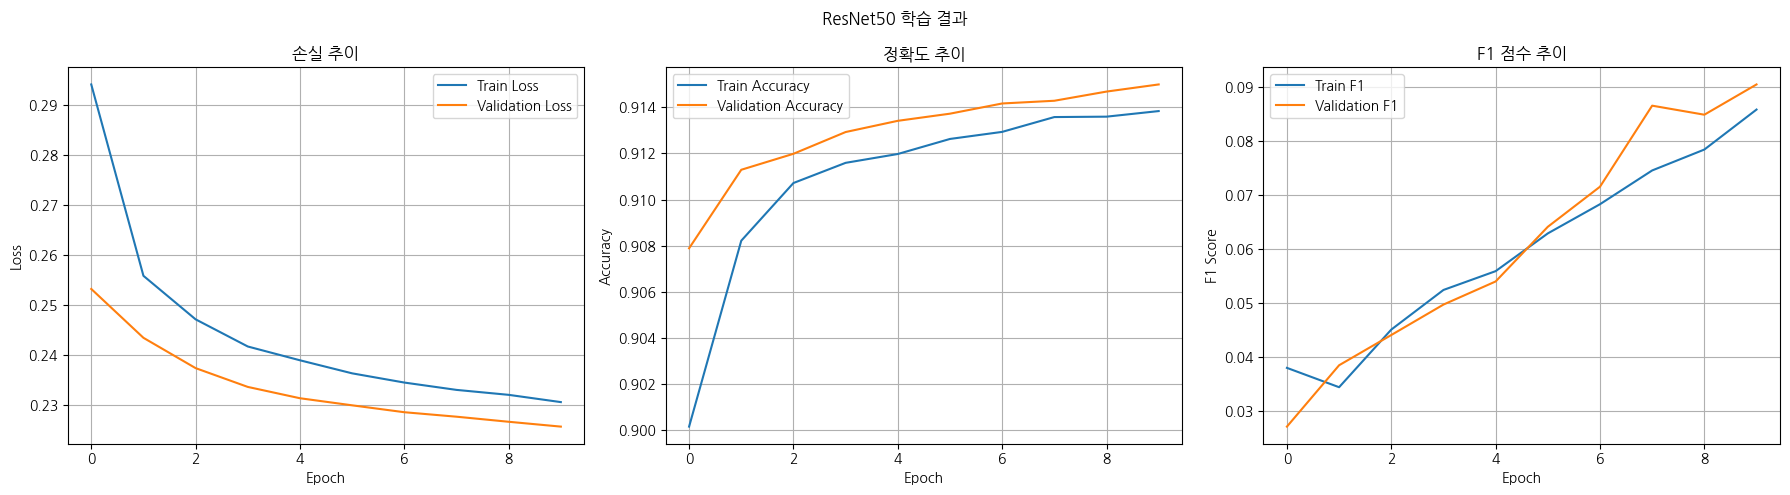

Testing:   0%|          | 0/488 [00:00<?, ?it/s]


ResNet50 평가 결과:
  loss: 0.2262
  accuracy: 0.9145
  precision_macro: 0.2566
  recall_macro: 0.0719
  f1_macro: 0.0898
  precision_micro: 0.6317
  recall_micro: 0.2538
  f1_micro: 0.3621
  roc_auc: nan
  mAP: 0.2371
모델 저장됨: saved_models/ResNet50_model_20250925_015634.pth
메모리 정리 중...
메모리 정리 완료
ResNet50 학습 및 저장 완료!
[2/8] ViT 학습 시작...
메모리 정리 중...
메모리 정리 완료
메모리 정리 중...
메모리 정리 완료
GPU 메모리 사용량:
- 할당된 메모리: 0.02 GB
- 예약된 메모리: 0.05 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.80 GB
모델이 cuda로 성공적으로 이동되었습니다.
모델 학습 시작: ViT
Epoch 1/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.3083, Val Loss: 0.2451
Train Acc: 0.8913, Val Acc: 0.9120
Train F1: 0.0606, Val F1: 0.0400
--------------------------------------------------
Epoch 2/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2437, Val Loss: 0.2313
Train Acc: 0.9119, Val Acc: 0.9142
Train F1: 0.0565, Val F1: 0.0575
--------------------------------------------------
Epoch 3/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2337, Val Loss: 0.2256
Train Acc: 0.9138, Val Acc: 0.9149
Train F1: 0.0846, Val F1: 0.0761
--------------------------------------------------
Epoch 4/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2279, Val Loss: 0.2216
Train Acc: 0.9151, Val Acc: 0.9161
Train F1: 0.1048, Val F1: 0.1039
--------------------------------------------------
Epoch 5/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2244, Val Loss: 0.2193
Train Acc: 0.9159, Val Acc: 0.9166
Train F1: 0.1182, Val F1: 0.1111
--------------------------------------------------
Epoch 6/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2217, Val Loss: 0.2173
Train Acc: 0.9163, Val Acc: 0.9169
Train F1: 0.1289, Val F1: 0.1236
--------------------------------------------------
Epoch 7/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2193, Val Loss: 0.2163
Train Acc: 0.9169, Val Acc: 0.9175
Train F1: 0.1378, Val F1: 0.1383
--------------------------------------------------
Epoch 8/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2176, Val Loss: 0.2147
Train Acc: 0.9176, Val Acc: 0.9175
Train F1: 0.1464, Val F1: 0.1376
--------------------------------------------------
Epoch 9/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2162, Val Loss: 0.2136
Train Acc: 0.9179, Val Acc: 0.9181
Train F1: 0.1519, Val F1: 0.1472
--------------------------------------------------
Epoch 10/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2144, Val Loss: 0.2130
Train Acc: 0.9181, Val Acc: 0.9181
Train F1: 0.1586, Val F1: 0.1519
--------------------------------------------------


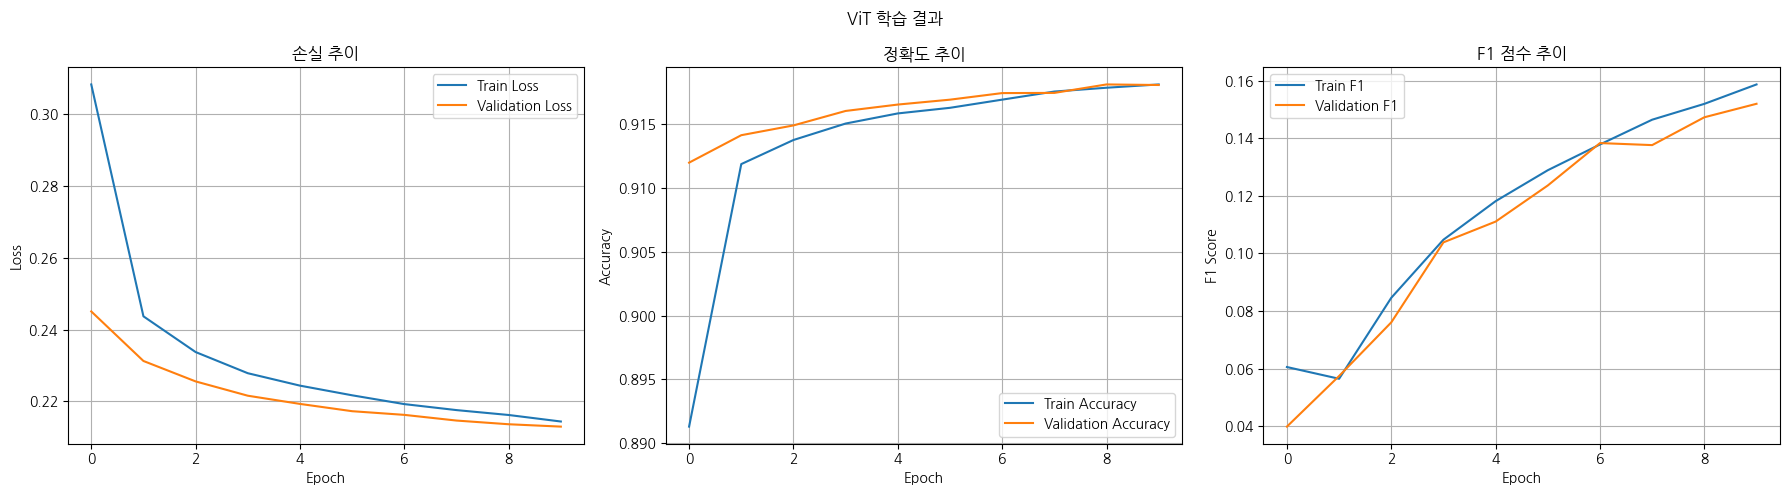

Testing:   0%|          | 0/488 [00:00<?, ?it/s]


ViT 평가 결과:
  loss: 0.2142
  accuracy: 0.9185
  precision_macro: 0.3899
  recall_macro: 0.1204
  f1_macro: 0.1610
  precision_micro: 0.6582
  recall_micro: 0.3076
  f1_micro: 0.4193
  roc_auc: nan
  mAP: 0.2918
모델 저장됨: saved_models/ViT_model_20250925_081408.pth
메모리 정리 중...
메모리 정리 완료
ViT 학습 및 저장 완료!
[3/8] BERT 학습 시작...
메모리 정리 중...
메모리 정리 완료
메모리 정리 중...
메모리 정리 완료
GPU 메모리 사용량:
- 할당된 메모리: 0.02 GB
- 예약된 메모리: 0.05 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.80 GB
모델이 cuda로 성공적으로 이동되었습니다.
모델 학습 시작: BERT
Epoch 1/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.3183, Val Loss: 0.2462
Train Acc: 0.8937, Val Acc: 0.9097
Train F1: 0.0432, Val F1: 0.0279
--------------------------------------------------
Epoch 2/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2434, Val Loss: 0.2261
Train Acc: 0.9103, Val Acc: 0.9138
Train F1: 0.0363, Val F1: 0.0458
--------------------------------------------------
Epoch 3/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2261, Val Loss: 0.2109
Train Acc: 0.9144, Val Acc: 0.9184
Train F1: 0.0794, Val F1: 0.1104
--------------------------------------------------
Epoch 4/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2138, Val Loss: 0.1996
Train Acc: 0.9185, Val Acc: 0.9218
Train F1: 0.1206, Val F1: 0.1432
--------------------------------------------------
Epoch 5/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2039, Val Loss: 0.1917
Train Acc: 0.9205, Val Acc: 0.9234
Train F1: 0.1473, Val F1: 0.1680
--------------------------------------------------
Epoch 6/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.1972, Val Loss: 0.1857
Train Acc: 0.9223, Val Acc: 0.9258
Train F1: 0.1737, Val F1: 0.2057
--------------------------------------------------
Epoch 7/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.1923, Val Loss: 0.1821
Train Acc: 0.9241, Val Acc: 0.9267
Train F1: 0.1989, Val F1: 0.2188
--------------------------------------------------
Epoch 8/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.1884, Val Loss: 0.1787
Train Acc: 0.9250, Val Acc: 0.9274
Train F1: 0.2172, Val F1: 0.2390
--------------------------------------------------
Epoch 9/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.1859, Val Loss: 0.1764
Train Acc: 0.9259, Val Acc: 0.9279
Train F1: 0.2350, Val F1: 0.2476
--------------------------------------------------
Epoch 10/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.1832, Val Loss: 0.1747
Train Acc: 0.9267, Val Acc: 0.9288
Train F1: 0.2460, Val F1: 0.2781
--------------------------------------------------


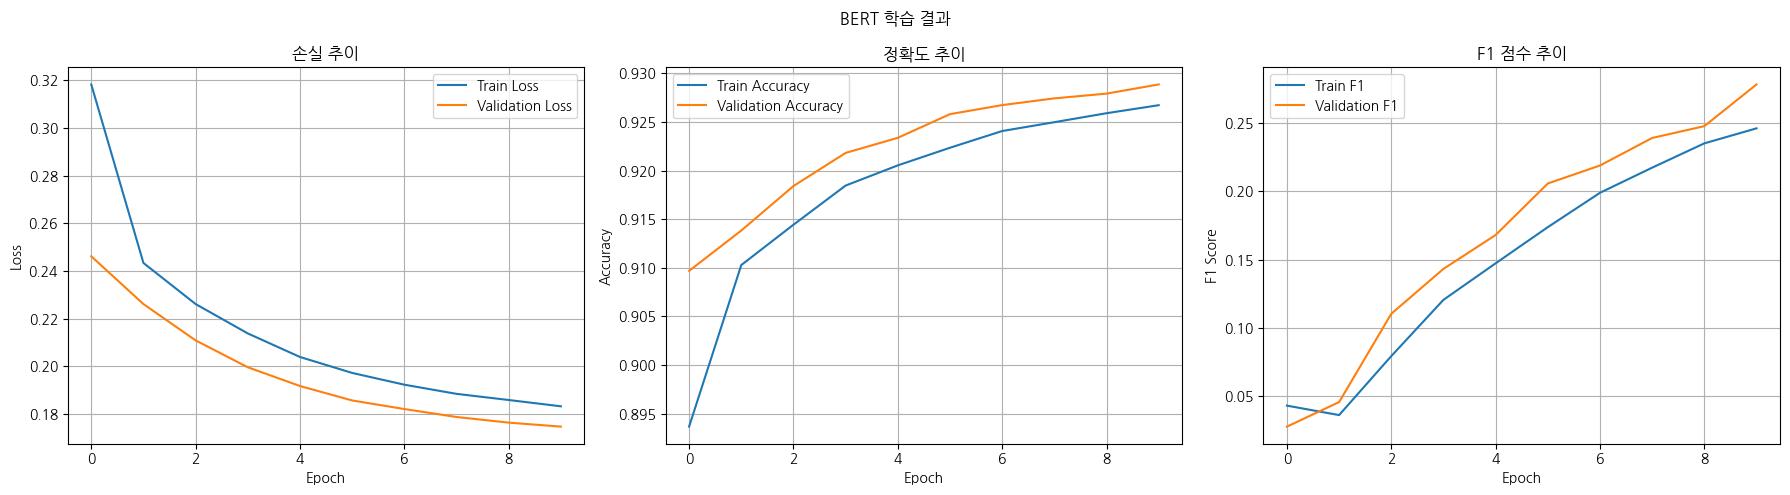

Testing:   0%|          | 0/488 [00:00<?, ?it/s]


BERT 평가 결과:
  loss: 0.1754
  accuracy: 0.9294
  precision_macro: 0.4962
  recall_macro: 0.2257
  f1_macro: 0.2784
  precision_micro: 0.7157
  recall_micro: 0.4339
  f1_micro: 0.5403
  roc_auc: nan
  mAP: 0.4379
모델 저장됨: saved_models/BERT_model_20250925_233417.pth
메모리 정리 중...
메모리 정리 완료
BERT 학습 및 저장 완료!
[4/8] RoBERTa 학습 시작...
메모리 정리 중...
메모리 정리 완료


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


메모리 정리 중...
메모리 정리 완료
GPU 메모리 사용량:
- 할당된 메모리: 0.02 GB
- 예약된 메모리: 0.05 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.80 GB
모델이 cuda로 성공적으로 이동되었습니다.
모델 학습 시작: RoBERTa
Epoch 1/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.3640, Val Loss: 0.2589
Train Acc: 0.8810, Val Acc: 0.9070
Train F1: 0.0552, Val F1: 0.0269
--------------------------------------------------
Epoch 2/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2701, Val Loss: 0.2563
Train Acc: 0.9068, Val Acc: 0.9070
Train F1: 0.0244, Val F1: 0.0269
--------------------------------------------------
Epoch 3/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2660, Val Loss: 0.2555
Train Acc: 0.9062, Val Acc: 0.9070
Train F1: 0.0239, Val F1: 0.0269
--------------------------------------------------
Epoch 4/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2620, Val Loss: 0.2549
Train Acc: 0.9067, Val Acc: 0.9070
Train F1: 0.0241, Val F1: 0.0269
--------------------------------------------------
Epoch 5/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2593, Val Loss: 0.2544
Train Acc: 0.9070, Val Acc: 0.9070
Train F1: 0.0244, Val F1: 0.0269
--------------------------------------------------
Epoch 6/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2577, Val Loss: 0.2542
Train Acc: 0.9071, Val Acc: 0.9070
Train F1: 0.0246, Val F1: 0.0269
--------------------------------------------------
Epoch 7/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2566, Val Loss: 0.2540
Train Acc: 0.9069, Val Acc: 0.9070
Train F1: 0.0246, Val F1: 0.0269
--------------------------------------------------
Epoch 8/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2558, Val Loss: 0.2538
Train Acc: 0.9073, Val Acc: 0.9070
Train F1: 0.0251, Val F1: 0.0269
--------------------------------------------------
Epoch 9/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2557, Val Loss: 0.2535
Train Acc: 0.9071, Val Acc: 0.9070
Train F1: 0.0249, Val F1: 0.0269
--------------------------------------------------
Epoch 10/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2550, Val Loss: 0.2532
Train Acc: 0.9073, Val Acc: 0.9070
Train F1: 0.0252, Val F1: 0.0269
--------------------------------------------------


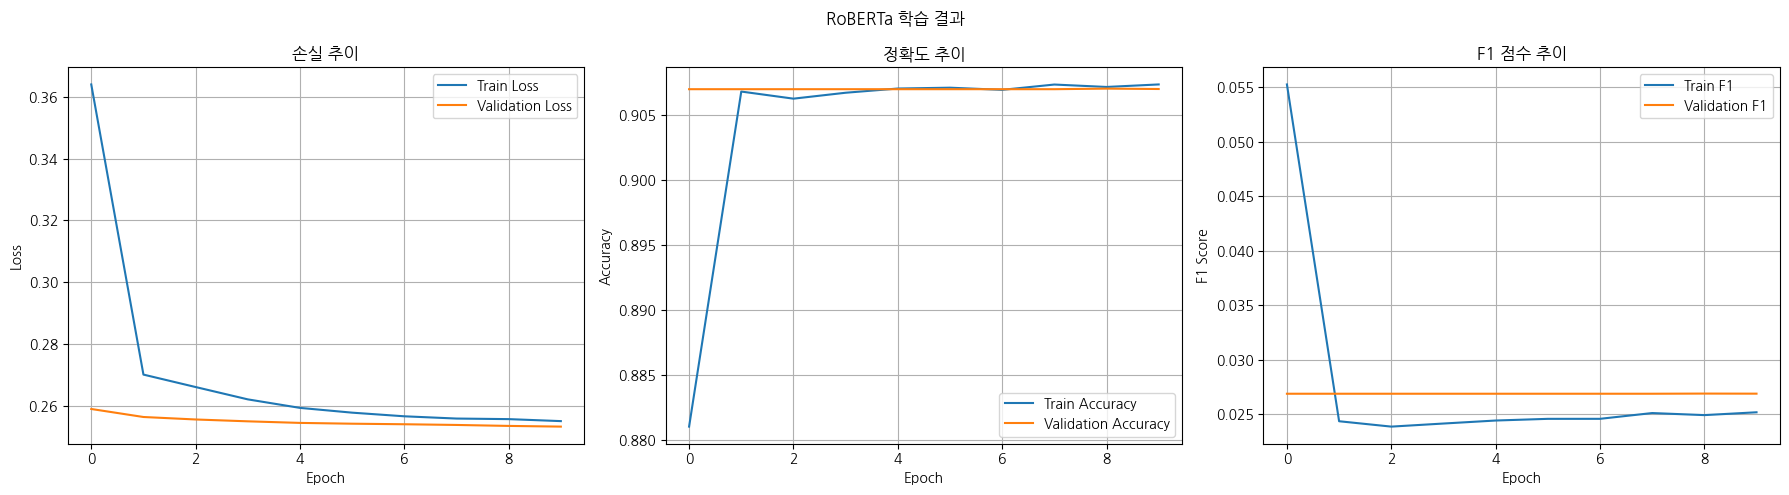

Testing:   0%|          | 0/488 [00:00<?, ?it/s]


RoBERTa 평가 결과:
  loss: 0.2533
  accuracy: 0.9068
  precision_macro: 0.0204
  recall_macro: 0.0385
  f1_macro: 0.0267
  precision_micro: 0.5310
  recall_micro: 0.2136
  f1_micro: 0.3046
  roc_auc: nan
  mAP: 0.1253
모델 저장됨: saved_models/RoBERTa_model_20250926_145032.pth
메모리 정리 중...
메모리 정리 완료
RoBERTa 학습 및 저장 완료!
[5/8] EarlyFusion 학습 시작...
메모리 정리 중...
메모리 정리 완료
메모리 정리 중...
메모리 정리 완료
GPU 메모리 사용량:
- 할당된 메모리: 0.02 GB
- 예약된 메모리: 0.05 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.80 GB
모델이 cuda로 성공적으로 이동되었습니다.
모델 학습 시작: EarlyFusion
Epoch 1/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2901, Val Loss: 0.2424
Train Acc: 0.9002, Val Acc: 0.9114
Train F1: 0.0391, Val F1: 0.0281
--------------------------------------------------
Epoch 2/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2404, Val Loss: 0.2184
Train Acc: 0.9117, Val Acc: 0.9167
Train F1: 0.0512, Val F1: 0.0715
--------------------------------------------------
Epoch 3/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2208, Val Loss: 0.2051
Train Acc: 0.9168, Val Acc: 0.9210
Train F1: 0.1029, Val F1: 0.1465
--------------------------------------------------
Epoch 4/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2084, Val Loss: 0.1941
Train Acc: 0.9202, Val Acc: 0.9253
Train F1: 0.1526, Val F1: 0.2053
--------------------------------------------------
Epoch 5/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2009, Val Loss: 0.1891
Train Acc: 0.9222, Val Acc: 0.9266
Train F1: 0.1864, Val F1: 0.2277
--------------------------------------------------
Epoch 6/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.1935, Val Loss: 0.1816
Train Acc: 0.9249, Val Acc: 0.9287
Train F1: 0.2109, Val F1: 0.2418
--------------------------------------------------
Epoch 7/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.1890, Val Loss: 0.1792
Train Acc: 0.9261, Val Acc: 0.9292
Train F1: 0.2254, Val F1: 0.2490
--------------------------------------------------
Epoch 8/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.1847, Val Loss: 0.1765
Train Acc: 0.9275, Val Acc: 0.9294
Train F1: 0.2430, Val F1: 0.2495
--------------------------------------------------
Epoch 9/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.1814, Val Loss: 0.1722
Train Acc: 0.9284, Val Acc: 0.9315
Train F1: 0.2557, Val F1: 0.2759
--------------------------------------------------
Epoch 10/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.1790, Val Loss: 0.1703
Train Acc: 0.9289, Val Acc: 0.9319
Train F1: 0.2648, Val F1: 0.2864
--------------------------------------------------


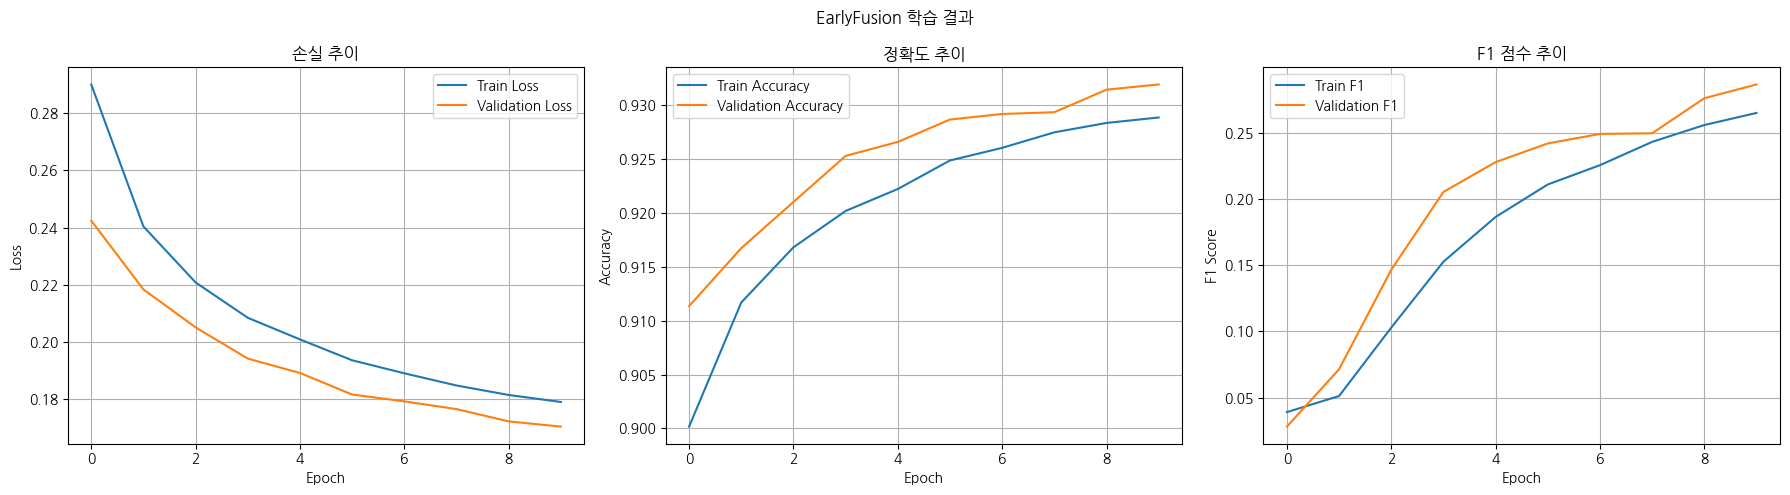

Testing:   0%|          | 0/488 [00:00<?, ?it/s]


EarlyFusion 평가 결과:
  loss: 0.1716
  accuracy: 0.9315
  precision_macro: 0.5184
  recall_macro: 0.2324
  f1_macro: 0.2849
  precision_micro: 0.7277
  recall_micro: 0.4531
  f1_micro: 0.5585
  roc_auc: nan
  mAP: 0.4526
모델 저장됨: saved_models/EarlyFusion_model_20250927_090034.pth
메모리 정리 중...
메모리 정리 완료
EarlyFusion 학습 및 저장 완료!
[6/8] LateFusion 학습 시작...
메모리 정리 중...
메모리 정리 완료
메모리 정리 중...
메모리 정리 완료
GPU 메모리 사용량:
- 할당된 메모리: 0.02 GB
- 예약된 메모리: 0.05 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.80 GB
모델이 cuda로 성공적으로 이동되었습니다.
모델 학습 시작: LateFusion
Epoch 1/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2805, Val Loss: 0.2417
Train Acc: 0.9057, Val Acc: 0.9111
Train F1: 0.0334, Val F1: 0.0303
--------------------------------------------------
Epoch 2/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2368, Val Loss: 0.2212
Train Acc: 0.9131, Val Acc: 0.9157
Train F1: 0.0433, Val F1: 0.0493
--------------------------------------------------
Epoch 3/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2194, Val Loss: 0.2078
Train Acc: 0.9170, Val Acc: 0.9200
Train F1: 0.0725, Val F1: 0.1047
--------------------------------------------------
Epoch 4/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2079, Val Loss: 0.1983
Train Acc: 0.9201, Val Acc: 0.9229
Train F1: 0.1148, Val F1: 0.1515
--------------------------------------------------
Epoch 5/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.1999, Val Loss: 0.1918
Train Acc: 0.9230, Val Acc: 0.9247
Train F1: 0.1551, Val F1: 0.1848
--------------------------------------------------
Epoch 6/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.1938, Val Loss: 0.1868
Train Acc: 0.9248, Val Acc: 0.9260
Train F1: 0.1829, Val F1: 0.2125
--------------------------------------------------
Epoch 7/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.1896, Val Loss: 0.1822
Train Acc: 0.9257, Val Acc: 0.9273
Train F1: 0.2009, Val F1: 0.2189
--------------------------------------------------
Epoch 8/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.1854, Val Loss: 0.1784
Train Acc: 0.9269, Val Acc: 0.9286
Train F1: 0.2188, Val F1: 0.2345
--------------------------------------------------
Epoch 9/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.1820, Val Loss: 0.1759
Train Acc: 0.9282, Val Acc: 0.9297
Train F1: 0.2365, Val F1: 0.2498
--------------------------------------------------
Epoch 10/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.1791, Val Loss: 0.1729
Train Acc: 0.9288, Val Acc: 0.9306
Train F1: 0.2488, Val F1: 0.2700
--------------------------------------------------


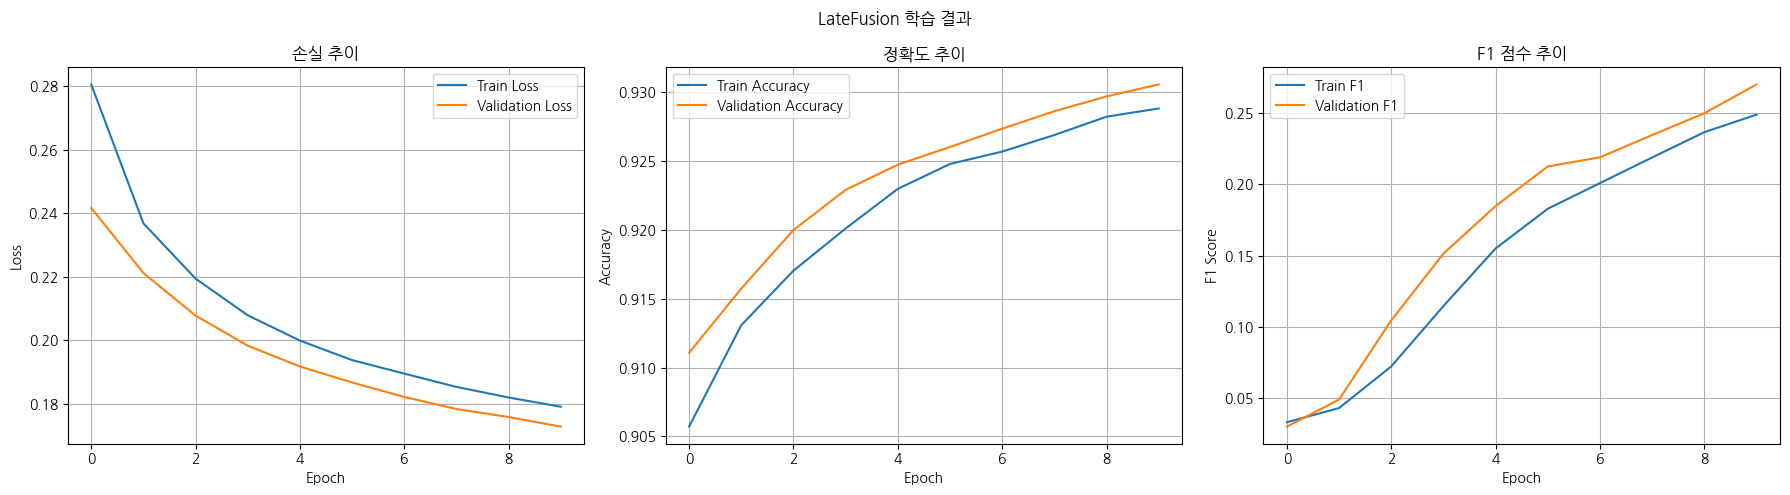

Testing:   0%|          | 0/488 [00:00<?, ?it/s]


LateFusion 평가 결과:
  loss: 0.1740
  accuracy: 0.9306
  precision_macro: 0.5268
  recall_macro: 0.2133
  f1_macro: 0.2686
  precision_micro: 0.7365
  recall_micro: 0.4266
  f1_micro: 0.5403
  roc_auc: nan
  mAP: 0.4486
모델 저장됨: saved_models/LateFusion_model_20250928_030958.pth
메모리 정리 중...
메모리 정리 완료
LateFusion 학습 및 저장 완료!
[7/8] AttentionFusion 학습 시작...
메모리 정리 중...
메모리 정리 완료
메모리 정리 중...
메모리 정리 완료
GPU 메모리 사용량:
- 할당된 메모리: 0.02 GB
- 예약된 메모리: 0.05 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.80 GB
모델이 cuda로 성공적으로 이동되었습니다.
모델 학습 시작: AttentionFusion
Epoch 1/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2989, Val Loss: 0.2542
Train Acc: 0.8950, Val Acc: 0.9071
Train F1: 0.0454, Val F1: 0.0269
--------------------------------------------------
Epoch 2/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2583, Val Loss: 0.2434
Train Acc: 0.9077, Val Acc: 0.9117
Train F1: 0.0344, Val F1: 0.0411
--------------------------------------------------
Epoch 3/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2471, Val Loss: 0.2363
Train Acc: 0.9105, Val Acc: 0.9128
Train F1: 0.0473, Val F1: 0.0492
--------------------------------------------------
Epoch 4/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2417, Val Loss: 0.2327
Train Acc: 0.9119, Val Acc: 0.9128
Train F1: 0.0559, Val F1: 0.0500
--------------------------------------------------
Epoch 5/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2381, Val Loss: 0.2304
Train Acc: 0.9121, Val Acc: 0.9138
Train F1: 0.0649, Val F1: 0.0644
--------------------------------------------------
Epoch 6/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2354, Val Loss: 0.2287
Train Acc: 0.9131, Val Acc: 0.9146
Train F1: 0.0752, Val F1: 0.0847
--------------------------------------------------
Epoch 7/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2339, Val Loss: 0.2272
Train Acc: 0.9134, Val Acc: 0.9148
Train F1: 0.0835, Val F1: 0.0862
--------------------------------------------------
Epoch 8/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2320, Val Loss: 0.2264
Train Acc: 0.9142, Val Acc: 0.9152
Train F1: 0.0893, Val F1: 0.1012
--------------------------------------------------
Epoch 9/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2313, Val Loss: 0.2255
Train Acc: 0.9141, Val Acc: 0.9151
Train F1: 0.0909, Val F1: 0.1012
--------------------------------------------------
Epoch 10/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2297, Val Loss: 0.2247
Train Acc: 0.9145, Val Acc: 0.9148
Train F1: 0.0969, Val F1: 0.1016
--------------------------------------------------


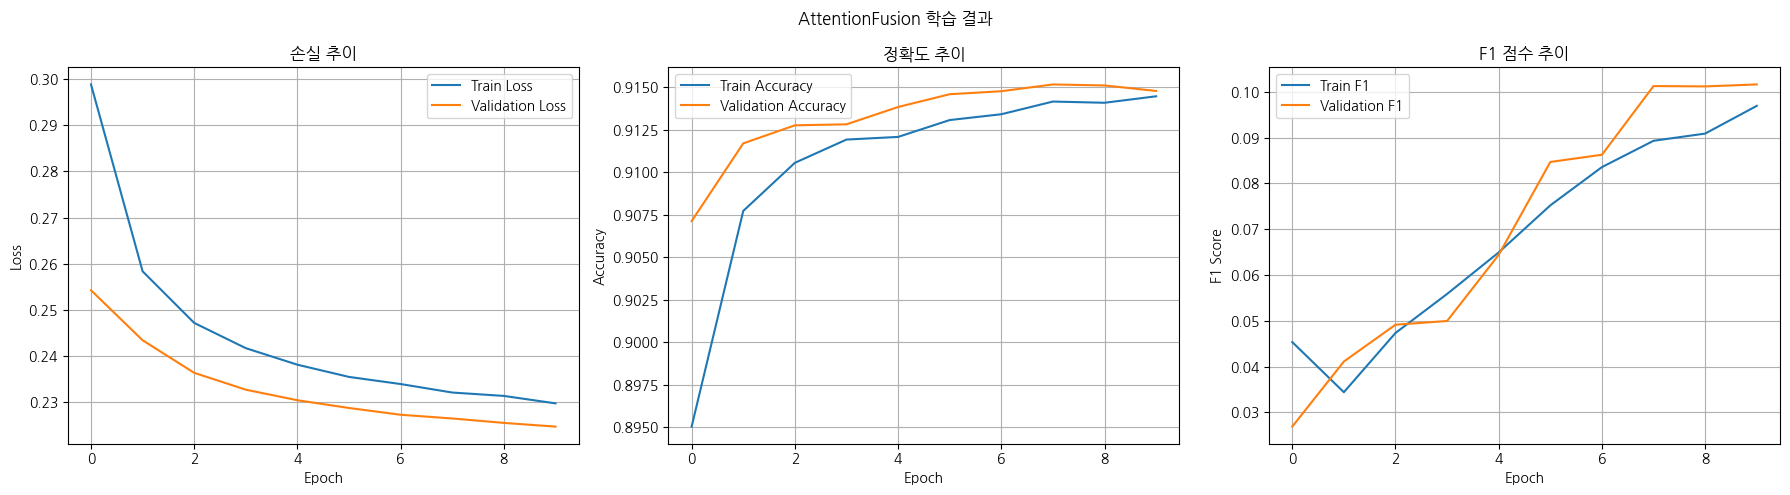

Testing:   0%|          | 0/488 [00:00<?, ?it/s]


AttentionFusion 평가 결과:
  loss: 0.2256
  accuracy: 0.9149
  precision_macro: 0.2837
  recall_macro: 0.0806
  f1_macro: 0.1033
  precision_micro: 0.6408
  recall_micro: 0.2510
  f1_micro: 0.3607
  roc_auc: nan
  mAP: 0.2387
모델 저장됨: saved_models/AttentionFusion_model_20250928_212001.pth
메모리 정리 중...
메모리 정리 완료
AttentionFusion 학습 및 저장 완료!
[8/8] CrossAttentionFusion 학습 시작...
메모리 정리 중...
메모리 정리 완료
메모리 정리 중...
메모리 정리 완료
GPU 메모리 사용량:
- 할당된 메모리: 0.02 GB
- 예약된 메모리: 0.05 GB
- 전체 메모리: 3.81 GB
- 사용 가능한 메모리: 3.80 GB
모델이 cuda로 성공적으로 이동되었습니다.
모델 학습 시작: CrossAttentionFusion
Epoch 1/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2756, Val Loss: 0.2143
Train Acc: 0.9052, Val Acc: 0.9156
Train F1: 0.0483, Val F1: 0.0731
--------------------------------------------------
Epoch 2/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.2058, Val Loss: 0.1797
Train Acc: 0.9212, Val Acc: 0.9283
Train F1: 0.1661, Val F1: 0.2294
--------------------------------------------------
Epoch 3/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.1869, Val Loss: 0.1694
Train Acc: 0.9261, Val Acc: 0.9327
Train F1: 0.2425, Val F1: 0.2855
--------------------------------------------------
Epoch 4/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.1784, Val Loss: 0.1646
Train Acc: 0.9290, Val Acc: 0.9349
Train F1: 0.2841, Val F1: 0.3453
--------------------------------------------------
Epoch 5/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.1734, Val Loss: 0.1622
Train Acc: 0.9308, Val Acc: 0.9357
Train F1: 0.3096, Val F1: 0.3652
--------------------------------------------------
Epoch 6/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.1694, Val Loss: 0.1602
Train Acc: 0.9322, Val Acc: 0.9356
Train F1: 0.3338, Val F1: 0.3782
--------------------------------------------------
Epoch 7/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.1660, Val Loss: 0.1569
Train Acc: 0.9330, Val Acc: 0.9372
Train F1: 0.3506, Val F1: 0.3816
--------------------------------------------------
Epoch 8/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.1635, Val Loss: 0.1561
Train Acc: 0.9344, Val Acc: 0.9373
Train F1: 0.3634, Val F1: 0.4105
--------------------------------------------------
Epoch 9/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.1620, Val Loss: 0.1534
Train Acc: 0.9348, Val Acc: 0.9385
Train F1: 0.3771, Val F1: 0.4147
--------------------------------------------------
Epoch 10/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 0.1597, Val Loss: 0.1543
Train Acc: 0.9357, Val Acc: 0.9383
Train F1: 0.3875, Val F1: 0.4144
--------------------------------------------------


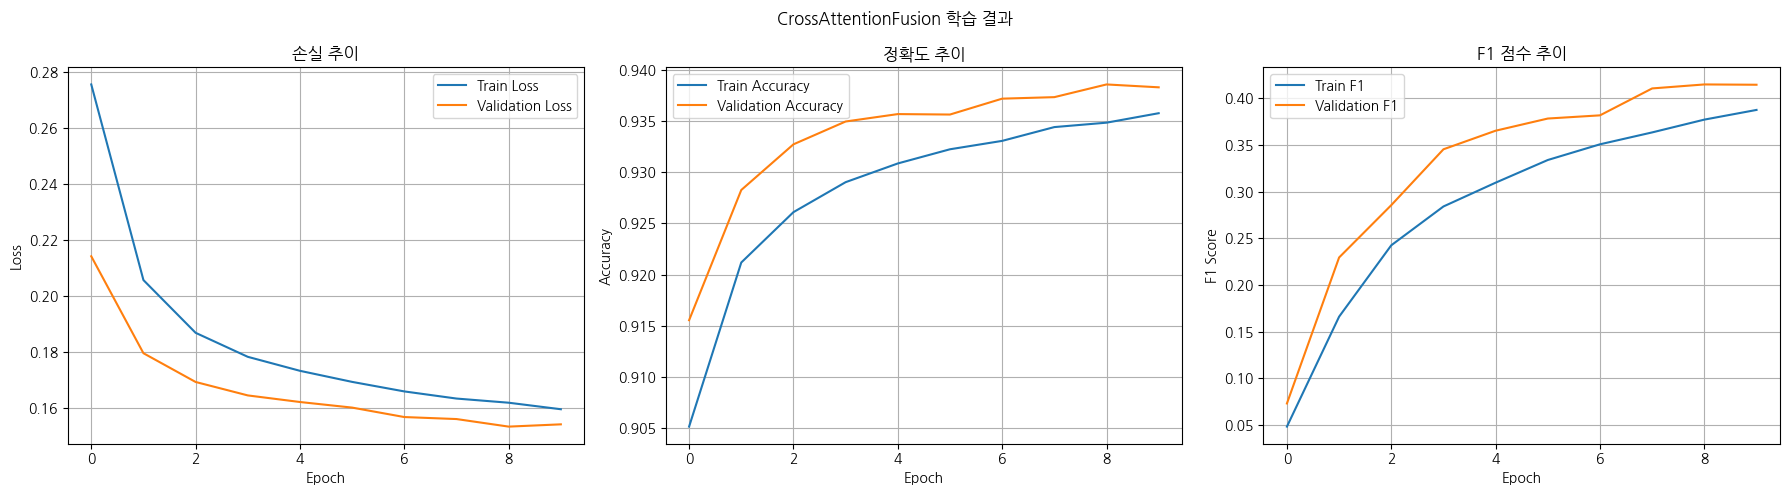

Testing:   0%|          | 0/488 [00:00<?, ?it/s]


CrossAttentionFusion 평가 결과:
  loss: 0.1555
  accuracy: 0.9375
  precision_macro: 0.5876
  recall_macro: 0.3460
  f1_macro: 0.4051
  precision_micro: 0.7427
  recall_micro: 0.5303
  f1_micro: 0.6188
  roc_auc: nan
  mAP: 0.5315
모델 저장됨: saved_models/CrossAttentionFusion_model_20250929_153335.pth
메모리 정리 중...
메모리 정리 완료
CrossAttentionFusion 학습 및 저장 완료!

🎉 모든 모델 학습 완료!


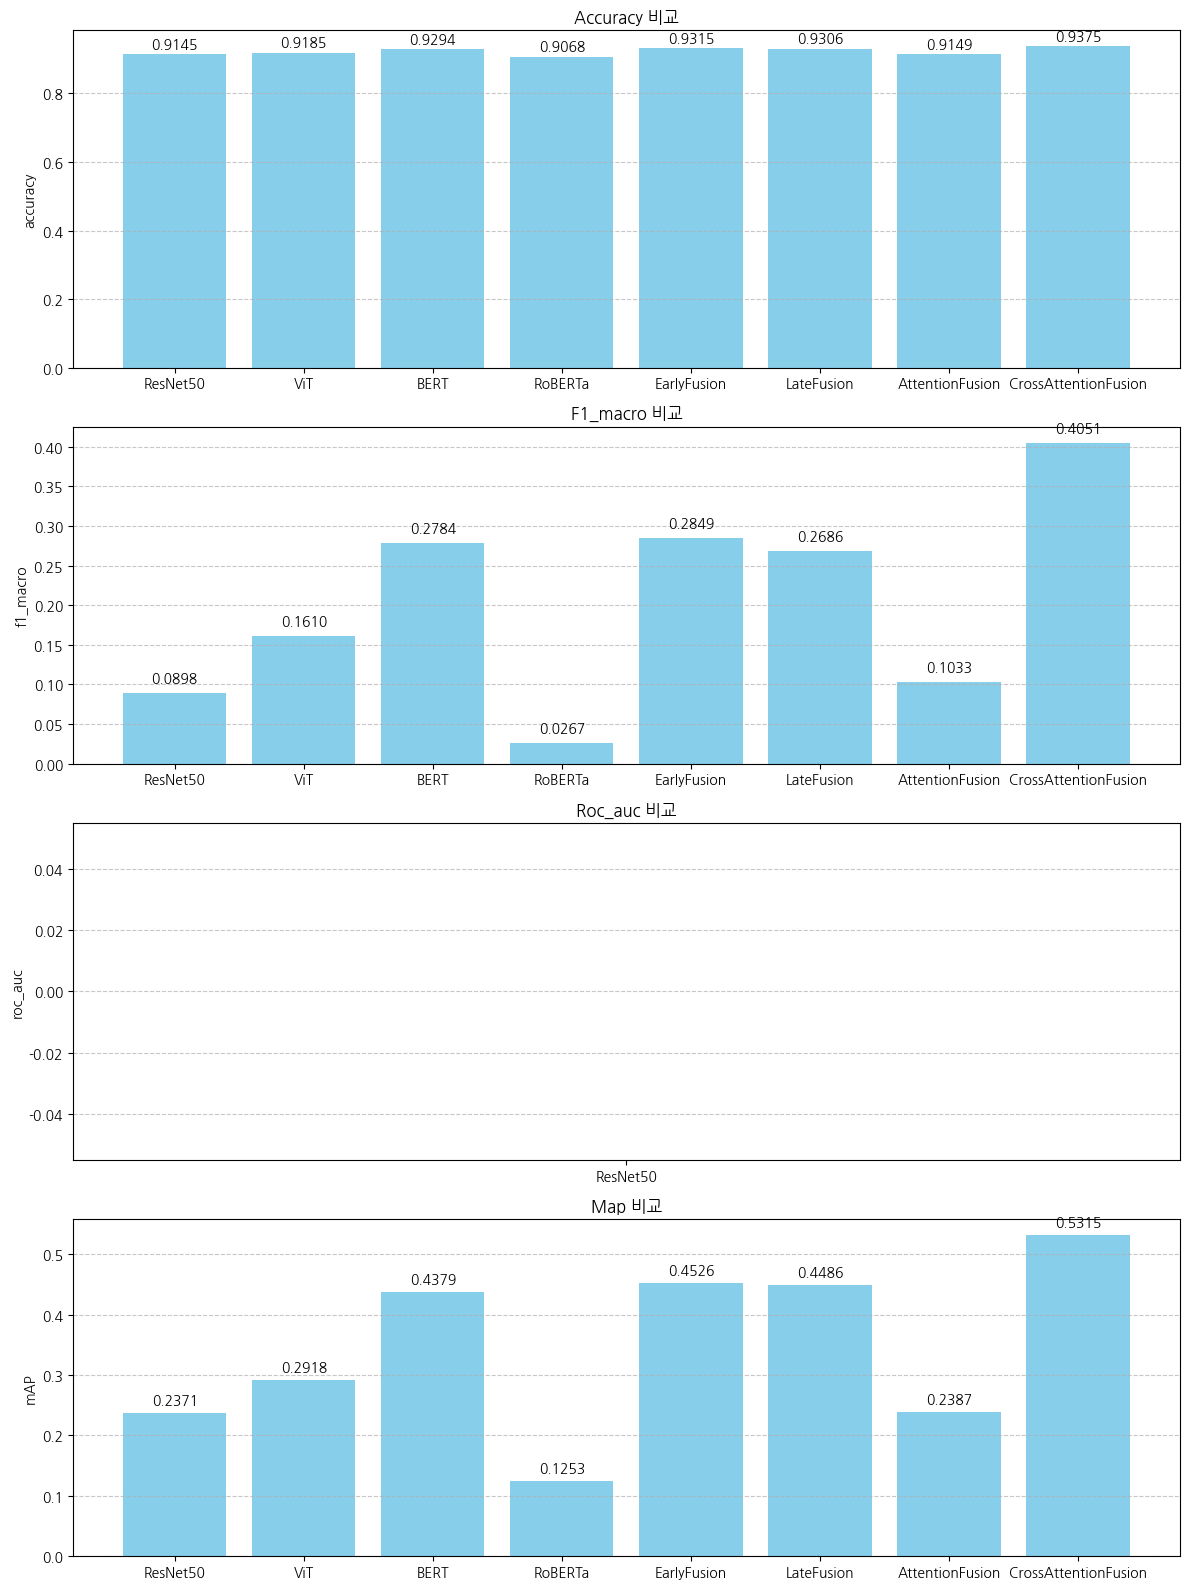


🏆 Best model: CrossAttentionFusion
   F1-macro score: 0.4051
모델 결과 저장됨: saved_models/model_results_20250929_153337.pkl
학습 변수들 저장됨: saved_models/comprehensive_training_variables.pkl

📊 최종 결과 요약:
- 총 시도한 모델 수: 8
- 성공한 모델 수: 8
- 실패한 모델 수: 0

📈 성공한 모델들의 F1-macro 점수:
  ResNet50: 0.0898
  ViT: 0.1610
  BERT: 0.2784
  RoBERTa: 0.0267
  EarlyFusion: 0.2849
  LateFusion: 0.2686
  AttentionFusion: 0.1033
  CrossAttentionFusion: 0.4051


In [27]:
# 메모리 효율적인 실험 설정 및 모델 학습

import os
import torch
import pickle
from datetime import datetime

# 모델 저장 디렉토리 생성
os.makedirs('saved_models', exist_ok=True)

# 손실 함수 정의 (멀티 레이블 분류)
criterion = nn.BCEWithLogitsLoss()

# 학습 파라미터
num_epochs = 10
learning_rate = 2e-5
weight_decay = 1e-4

# 모델 결과 저장을 위한 딕셔너리
model_results = {}

# 학습할 모델 정의 (한 번에 하나씩 생성하여 메모리 절약)
models_config = {
    # 단일 모달 모델
    'ResNet50': {'type': 'single', 'modality': 'image', 'extractor': 'resnet50'},
    'ViT': {'type': 'single', 'modality': 'image', 'extractor': 'vit'},
    'BERT': {'type': 'single', 'modality': 'text', 'extractor': 'bert'},
    'RoBERTa': {'type': 'single', 'modality': 'text', 'extractor': 'roberta'},
    
    # 멀티모달 모델
    'EarlyFusion': {'type': 'multi', 'img_extractor': 'resnet50', 'text_extractor': 'bert', 'fusion_method': 'early'},
    'LateFusion': {'type': 'multi', 'img_extractor': 'resnet50', 'text_extractor': 'bert', 'fusion_method': 'late'},
    'AttentionFusion': {'type': 'multi', 'img_extractor': 'resnet50', 'text_extractor': 'bert', 'fusion_method': 'attention'},
    'CrossAttentionFusion': {'type': 'multi', 'img_extractor': 'resnet50', 'text_extractor': 'bert', 'fusion_method': 'cross-attention'}
}

print(f"총 {len(models_config)}개의 모델을 순차적으로 학습합니다.")
print("각 모델 학습 후 메모리를 정리하여 OutOfMemory 오류를 방지합니다.\n")

# 각 모델을 순차적으로 학습 (메모리 효율성을 위해)
for i, (model_name, config) in enumerate(models_config.items(), 1):
    print(f"[{i}/{len(models_config)}] {model_name} 학습 시작...")
    
    # 이전 모델 변수들 정리
    if 'model' in locals():
        del model
    if 'optimizer' in locals():
        del optimizer
    if 'scheduler' in locals():
        del scheduler
    
    # 메모리 정리
    clear_memory()
    
    try:
        # 모델 생성
        if config['type'] == 'single':
            model = SingleModalModel(
                len(genre_list), 
                modality=config['modality'], 
                extractor=config['extractor']
            )
        else:  # multi
            model = MultimodalModel(
                len(genre_list),
                img_extractor=config['img_extractor'],
                text_extractor=config['text_extractor'],
                fusion_method=config['fusion_method']
            )
        
        # 모델을 안전하게 디바이스로 이동
        model = safe_model_to_device(model, device)
        
        # 옵티마이저 정의
        optimizer = optim.AdamW(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=learning_rate,
            weight_decay=weight_decay
        )
        
        # 학습률 스케줄러
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=2
        )
        
        print(f"모델 학습 시작: {model_name}")
        
        # 모델 학습
        model, history = train_model(
            model, train_loader, val_loader,
            criterion, optimizer, scheduler,
            num_epochs=num_epochs, device=device
        )
        
        # 학습 과정 시각화
        plot_training_history(history, title=f'{model_name} 학습 결과')
        
        # 테스트 세트에서 모델 평가
        metrics, preds, probs, targets = evaluate_model(model, test_loader, criterion, device)
        
        # 결과 출력
        print(f"\n{model_name} 평가 결과:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.4f}")
        
        # 결과 저장
        model_results[model_name] = metrics
        
        # 모델 저장
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model_save_path = f'saved_models/{model_name}_model_{timestamp}.pth'
        
        # 모델 설정 정보 생성
        if config['type'] == 'single':
            model_config = {
                'model_name': model_name,
                'type': 'single_modal',
                'num_classes': len(genre_list),
                'modality': config['modality'],
                'extractor': config['extractor'],
                'genre_list': genre_list,
                'genre_to_idx': genre_to_idx,
                'idx_to_genre': idx_to_genre
            }
        else:
            model_config = {
                'model_name': model_name,
                'type': 'multimodal',
                'num_classes': len(genre_list),
                'img_extractor': config['img_extractor'],
                'text_extractor': config['text_extractor'],
                'fusion_method': config['fusion_method'],
                'freeze_extractors': False,
                'genre_list': genre_list,
                'genre_to_idx': genre_to_idx,
                'idx_to_genre': idx_to_genre
            }
        
        torch.save({
            'model_state_dict': model.state_dict(),
            'model_config': model_config,
            'metrics': metrics,
            'history': history,
            'num_epochs': num_epochs,
            'learning_rate': learning_rate,
            'weight_decay': weight_decay,
            'predictions': preds,
            'probabilities': probs,
            'targets': targets
        }, model_save_path)
        
        print(f"모델 저장됨: {model_save_path}")
        
        # 모델을 CPU로 이동하여 GPU 메모리 해제
        model = model.cpu()
        
        # 메모리 정리
        clear_memory()
        
        print(f"{model_name} 학습 및 저장 완료!")
        print("=" * 60)
        
    except Exception as e:
        print(f"❌ {model_name} 학습 중 오류 발생: {e}")
        
        # 오류 발생 시에도 메모리 정리
        if 'model' in locals():
            model = model.cpu()
        clear_memory()
        
        # 오류를 기록하지만 다음 모델 학습을 계속 진행
        model_results[model_name] = {'error': str(e)}
        print(f"다음 모델로 계속 진행합니다...")
        print("=" * 60)
        continue

print("\n🎉 모든 모델 학습 완료!")

# 성공적으로 학습된 모델들만 필터링
successful_results = {k: v for k, v in model_results.items() if 'error' not in v}

if successful_results:
    # 모델 비교 시각화 (성공한 모델들만)
    plot_model_comparison(successful_results)
    
    # 가장 성능이 좋은 모델 선택 (F1 점수 기준)
    best_model_name = max(successful_results, key=lambda k: successful_results[k]['f1_macro'])
    print(f"\n🏆 Best model: {best_model_name}")
    print(f"   F1-macro score: {successful_results[best_model_name]['f1_macro']:.4f}")
else:
    print("❌ 성공적으로 학습된 모델이 없습니다.")
    best_model_name = None

# 모델 결과를 파일로 저장
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_save_path = f'saved_models/model_results_{timestamp}.pkl'
with open(results_save_path, 'wb') as f:
    pickle.dump(model_results, f)
print(f"모델 결과 저장됨: {results_save_path}")

# 주요 변수들을 pickle 파일로 저장 (Cell 25에서 로드하기 위해)
training_variables = {
    'model_results': model_results,
    'successful_results': successful_results,
    'best_model_name': best_model_name,
    'timestamp': timestamp,
    'criterion': criterion,
    'train_loader': train_loader,
    'val_loader': val_loader,
    'test_loader': test_loader,
    'num_epochs': num_epochs,
    'learning_rate': learning_rate,
    'weight_decay': weight_decay,
    'device': device,
    'genre_list': genre_list,
    'genre_to_idx': genre_to_idx,
    'idx_to_genre': idx_to_genre,
    'models_config': models_config
}

training_variables_path = 'saved_models/comprehensive_training_variables.pkl'
with open(training_variables_path, 'wb') as f:
    pickle.dump(training_variables, f)
print(f"학습 변수들 저장됨: {training_variables_path}")

print(f"\n📊 최종 결과 요약:")
print(f"- 총 시도한 모델 수: {len(models_config)}")
print(f"- 성공한 모델 수: {len(successful_results)}")
print(f"- 실패한 모델 수: {len(models_config) - len(successful_results)}")

if successful_results:
    print(f"\n📈 성공한 모델들의 F1-macro 점수:")
    for model_name, metrics in successful_results.items():
        print(f"  {model_name}: {metrics['f1_macro']:.4f}")

In [19]:
# 필요한 라이브러리와 모델 클래스 import 및 정의
import glob
import pickle
import os
import numpy as np
from datetime import datetime

# 개별 모델 클래스 정의 (Cell 25에서 필요)
class ResNet50Model(SingleModalModel):
    def __init__(self, num_classes):
        super(ResNet50Model, self).__init__(num_classes, modality='image', extractor='resnet50')

class ViTModel(SingleModalModel):
    def __init__(self, num_classes):
        super(ViTModel, self).__init__(num_classes, modality='image', extractor='vit')

class BERTModel(SingleModalModel):
    def __init__(self, num_classes):
        super(BERTModel, self).__init__(num_classes, modality='text', extractor='bert')

class RoBERTaModel(SingleModalModel):
    def __init__(self, num_classes):
        super(RoBERTaModel, self).__init__(num_classes, modality='text', extractor='roberta')

class EarlyFusionModel(MultimodalModel):
    def __init__(self, num_classes):
        super(EarlyFusionModel, self).__init__(num_classes, fusion_method='early')

class LateFusionModel(MultimodalModel):
    def __init__(self, num_classes):
        super(LateFusionModel, self).__init__(num_classes, fusion_method='late')

class AttentionFusionModel(MultimodalModel):
    def __init__(self, num_classes):
        super(AttentionFusionModel, self).__init__(num_classes, fusion_method='attention')

class CrossAttentionFusionModel(MultimodalModel):
    def __init__(self, num_classes):
        # 실제 구현된 이름은 'cross-attention'
        super(CrossAttentionFusionModel, self).__init__(num_classes, fusion_method='cross-attention')

# ROC-AUC 메트릭 재계산 및 기존 결과 업데이트
print("기존 모델들의 ROC-AUC 메트릭을 재계산하고 저장합니다...")

# 저장된 모델 결과 로드
results_file_path = '/home/mingky/workspace/mmimdb_test/saved_models/model_results_20250929_153337.pkl'

try:
    with open(results_file_path, 'rb') as f:
        model_results = pickle.load(f)
    print(f"기존 결과 파일 로드 완료: {results_file_path}")
except:
    print("기존 결과 파일을 찾을 수 없습니다. 새로운 딕셔너리를 생성합니다.")
    model_results = {}

# 현재 학습된 모든 모델들에 대해 ROC-AUC 재계산
trained_models = ['ResNet50', 'ViT', 'BERT', 'RoBERTa', 'EarlyFusion', 'LateFusion', 'AttentionFusion', 'CrossAttentionFusion']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for model_name in trained_models:
    print(f"\n=== {model_name} ROC-AUC 재계산 중... ===")
    
    try:
        # 모델 파일 경로 설정
        model_file_pattern = f'/home/mingky/workspace/mmimdb_test/saved_models/{model_name}_model_*.pth'
        model_files = glob.glob(model_file_pattern)
        
        if not model_files:
            print(f"  {model_name} 모델 파일을 찾을 수 없습니다.")
            continue
            
        # 가장 최근 파일 선택
        model_file = max(model_files, key=os.path.getctime)
        print(f"  모델 로드 중: {model_file}")
        
        # 해당 모델 인스턴스 생성 및 로드
        if model_name == 'ResNet50':
            model = ResNet50Model(num_classes=len(genre_list)).to(device)
        elif model_name == 'ViT':
            model = ViTModel(num_classes=len(genre_list)).to(device)
        elif model_name == 'BERT':
            model = BERTModel(num_classes=len(genre_list)).to(device)
        elif model_name == 'RoBERTa':
            model = RoBERTaModel(num_classes=len(genre_list)).to(device)
        elif model_name == 'EarlyFusion':
            model = EarlyFusionModel(num_classes=len(genre_list)).to(device)
        elif model_name == 'LateFusion':
            model = LateFusionModel(num_classes=len(genre_list)).to(device)
        elif model_name == 'AttentionFusion':
            model = AttentionFusionModel(num_classes=len(genre_list)).to(device)
        elif model_name == 'CrossAttentionFusion':
            model = CrossAttentionFusionModel(num_classes=len(genre_list)).to(device)
        
        # 모델 가중치 로드 (체크포인트 형식 지원)
        try:
            checkpoint = torch.load(model_file, map_location=device, weights_only=False)
            
            # 체크포인트 형식인지 확인하고 적절히 로드
            if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
                # 전체 체크포인트 형식
                model.load_state_dict(checkpoint['model_state_dict'], strict=False)
                print(f"    체크포인트 형식으로 로드됨")
            else:
                # 단순 state_dict 형식
                model.load_state_dict(checkpoint, strict=False)
                print(f"    state_dict 형식으로 로드됨")
            
            model.eval()
            
        except Exception as load_error:
            print(f"    모델 로드 실패: {load_error}")
            continue
        
        # 평가 실행
        print(f"  {model_name} 평가 중...")
        
        # criterion 정의 (BCEWithLogitsLoss)
        criterion = nn.BCEWithLogitsLoss()
        
        # 모델 평가 실행 (evaluate_model 함수는 4개 값을 반환)
        evaluation_result = evaluate_model(model, test_loader, criterion, device)
        
        # 반환값 처리 (튜플인지 딕셔너리인지 확인)
        if isinstance(evaluation_result, tuple) and len(evaluation_result) == 4:
            metrics, preds, probs, targets = evaluation_result
        else:
            metrics = evaluation_result
        
        # 결과 업데이트
        model_results[model_name] = metrics
        
        # 결과 출력
        print(f"  {model_name} 재계산 완료:")
        print(f"    정확도: {metrics['accuracy']:.4f}")
        print(f"    정밀도: {metrics['precision']:.4f}")
        print(f"    재현율: {metrics['recall']:.4f}")
        print(f"    F1-Score: {metrics['f1']:.4f}")
        
        # 안전한 포맷팅으로 수정
        roc_auc = metrics.get('roc_auc', 'N/A')
        roc_auc_micro = metrics.get('roc_auc_micro', 'N/A')
        mAP = metrics.get('mAP', 'N/A')
        mAP_micro = metrics.get('mAP_micro', 'N/A')
        
        roc_auc_str = f"{roc_auc:.4f}" if isinstance(roc_auc, (int, float)) and not np.isnan(roc_auc) else str(roc_auc)
        roc_auc_micro_str = f"{roc_auc_micro:.4f}" if isinstance(roc_auc_micro, (int, float)) and not np.isnan(roc_auc_micro) else str(roc_auc_micro)
        mAP_str = f"{mAP:.4f}" if isinstance(mAP, (int, float)) and not np.isnan(mAP) else str(mAP)
        mAP_micro_str = f"{mAP_micro:.4f}" if isinstance(mAP_micro, (int, float)) and not np.isnan(mAP_micro) else str(mAP_micro)
        
        print(f"    ROC-AUC (macro): {roc_auc_str}")
        print(f"    ROC-AUC (micro): {roc_auc_micro_str}")
        print(f"    mAP (macro): {mAP_str}")
        print(f"    mAP (micro): {mAP_micro_str}")
        
    except Exception as e:
        print(f"  {model_name} 처리 중 오류 발생: {e}")
        continue

# 업데이트된 결과 저장
try:
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    updated_results_file = f'/home/mingky/workspace/mmimdb_test/saved_models/model_results_updated_{timestamp}.pkl'
    
    with open(updated_results_file, 'wb') as f:
        pickle.dump(model_results, f)
    
    # 기존 파일도 업데이트
    with open(results_file_path, 'wb') as f:
        pickle.dump(model_results, f)
    
    print(f"\n✅ 업데이트된 결과 저장 완료!")
    print(f"   - 새 파일: {updated_results_file}")
    print(f"   - 기존 파일 업데이트: {results_file_path}")
    
except Exception as e:
    print(f"\n❌ 결과 저장 중 오류: {e}")

# 최종 결과 요약
print("\n" + "="*50)
print("ROC-AUC 재계산 결과 요약")
print("="*50)

for model_name in trained_models:
    if model_name in model_results:
        metrics = model_results[model_name]
        roc_auc = metrics.get('roc_auc', 'N/A')
        roc_auc_micro = metrics.get('roc_auc_micro', 'N/A')
        
        # float 값을 문자열로 변환하여 포맷팅
        roc_auc_str = f"{roc_auc:.4f}" if isinstance(roc_auc, (int, float)) else str(roc_auc)
        roc_auc_micro_str = f"{roc_auc_micro:.4f}" if isinstance(roc_auc_micro, (int, float)) else str(roc_auc_micro)
        
        print(f"{model_name:20s} | ROC-AUC(macro): {roc_auc_str:>8s} | ROC-AUC(micro): {roc_auc_micro_str:>8s}")
    else:
        print(f"{model_name:20s} | 계산 실패")

print("="*50)

기존 모델들의 ROC-AUC 메트릭을 재계산하고 저장합니다...
기존 결과 파일 로드 완료: /home/mingky/workspace/mmimdb_test/saved_models/model_results_20250929_153337.pkl

=== ResNet50 ROC-AUC 재계산 중... ===
  모델 로드 중: /home/mingky/workspace/mmimdb_test/saved_models/ResNet50_model_20250925_015634.pth
    체크포인트 형식으로 로드됨
  ResNet50 평가 중...
    체크포인트 형식으로 로드됨
  ResNet50 평가 중...


Testing:   0%|          | 0/488 [00:00<?, ?it/s]

  ResNet50 재계산 완료:
    정확도: 0.9145
  ResNet50 처리 중 오류 발생: 'precision'

=== ViT ROC-AUC 재계산 중... ===
  모델 로드 중: /home/mingky/workspace/mmimdb_test/saved_models/ViT_model_20250925_081408.pth
    체크포인트 형식으로 로드됨
  ViT 평가 중...
    체크포인트 형식으로 로드됨
  ViT 평가 중...


Testing:   0%|          | 0/488 [00:00<?, ?it/s]

  ViT 재계산 완료:
    정확도: 0.9185
  ViT 처리 중 오류 발생: 'precision'

=== BERT ROC-AUC 재계산 중... ===
  모델 로드 중: /home/mingky/workspace/mmimdb_test/saved_models/BERT_model_20250925_233417.pth
    체크포인트 형식으로 로드됨
  BERT 평가 중...
    체크포인트 형식으로 로드됨
  BERT 평가 중...


Testing:   0%|          | 0/488 [00:00<?, ?it/s]

  BERT 재계산 완료:
    정확도: 0.9294
  BERT 처리 중 오류 발생: 'precision'

=== RoBERTa ROC-AUC 재계산 중... ===
  모델 로드 중: /home/mingky/workspace/mmimdb_test/saved_models/RoBERTa_model_20250926_145032.pth


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


    체크포인트 형식으로 로드됨
  RoBERTa 평가 중...


Testing:   0%|          | 0/488 [00:00<?, ?it/s]

  RoBERTa 재계산 완료:
    정확도: 0.9068
  RoBERTa 처리 중 오류 발생: 'precision'

=== EarlyFusion ROC-AUC 재계산 중... ===
  모델 로드 중: /home/mingky/workspace/mmimdb_test/saved_models/EarlyFusion_model_20250927_090034.pth
    체크포인트 형식으로 로드됨
  EarlyFusion 평가 중...
    체크포인트 형식으로 로드됨
  EarlyFusion 평가 중...


Testing:   0%|          | 0/488 [00:00<?, ?it/s]

  EarlyFusion 재계산 완료:
    정확도: 0.9315
  EarlyFusion 처리 중 오류 발생: 'precision'

=== LateFusion ROC-AUC 재계산 중... ===
  모델 로드 중: /home/mingky/workspace/mmimdb_test/saved_models/LateFusion_model_20250928_030958.pth
    체크포인트 형식으로 로드됨
  LateFusion 평가 중...
    체크포인트 형식으로 로드됨
  LateFusion 평가 중...


Testing:   0%|          | 0/488 [00:00<?, ?it/s]

  LateFusion 재계산 완료:
    정확도: 0.9306
  LateFusion 처리 중 오류 발생: 'precision'

=== AttentionFusion ROC-AUC 재계산 중... ===
  모델 로드 중: /home/mingky/workspace/mmimdb_test/saved_models/AttentionFusion_model_20250928_212001.pth
    체크포인트 형식으로 로드됨
  AttentionFusion 평가 중...
    체크포인트 형식으로 로드됨
  AttentionFusion 평가 중...


Testing:   0%|          | 0/488 [00:00<?, ?it/s]

  AttentionFusion 재계산 완료:
    정확도: 0.9149
  AttentionFusion 처리 중 오류 발생: 'precision'

=== CrossAttentionFusion ROC-AUC 재계산 중... ===
  모델 로드 중: /home/mingky/workspace/mmimdb_test/saved_models/CrossAttentionFusion_model_20250929_153335.pth
    체크포인트 형식으로 로드됨
  CrossAttentionFusion 평가 중...
    체크포인트 형식으로 로드됨
  CrossAttentionFusion 평가 중...


Testing:   0%|          | 0/488 [00:00<?, ?it/s]

  CrossAttentionFusion 재계산 완료:
    정확도: 0.9375
  CrossAttentionFusion 처리 중 오류 발생: 'precision'

✅ 업데이트된 결과 저장 완료!
   - 새 파일: /home/mingky/workspace/mmimdb_test/saved_models/model_results_updated_20250929_225607.pkl
   - 기존 파일 업데이트: /home/mingky/workspace/mmimdb_test/saved_models/model_results_20250929_153337.pkl

ROC-AUC 재계산 결과 요약
ResNet50             | ROC-AUC(macro):   0.7293 | ROC-AUC(micro):   0.8614
ViT                  | ROC-AUC(macro):   0.7728 | ROC-AUC(micro):   0.8799
BERT                 | ROC-AUC(macro):   0.8850 | ROC-AUC(micro):   0.9300
RoBERTa              | ROC-AUC(macro):   0.5910 | ROC-AUC(micro):   0.8110
EarlyFusion          | ROC-AUC(macro):   0.8912 | ROC-AUC(micro):   0.9326
LateFusion           | ROC-AUC(macro):   0.8902 | ROC-AUC(micro):   0.9315
AttentionFusion      | ROC-AUC(macro):   0.7331 | ROC-AUC(micro):   0.8620
CrossAttentionFusion | ROC-AUC(macro):   0.9171 | ROC-AUC(micro):   0.9466


## 저장된 모델 불러오기 및 사용

In [36]:
# Cell 24에서 생성된 모델들을 불러오는 함수
def load_saved_model(model_path, device):
    """
    저장된 모델을 불러오는 함수
    
    Args:
        model_path (str): 저장된 모델 파일 경로
        device: PyTorch 디바이스
    
    Returns:
        tuple: (model, model_info)
    """
    # 저장된 데이터 로드 (PyTorch 2.6 호환성을 위해 weights_only=False 설정)
    try:
        # 먼저 weights_only=True로 시도
        checkpoint = torch.load(model_path, map_location=device, weights_only=True)
    except Exception as e:
        print(f"weights_only=True로 로딩 실패, weights_only=False로 재시도...")
        # 실패하면 weights_only=False로 재시도 (신뢰할 수 있는 파일인 경우)
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    # 모델 설정 정보 추출
    model_config = checkpoint['model_config']
    model_name = model_config['model_name']
    
    print(f"모델 정보:")
    print(f"- 모델 이름: {model_name}")
    print(f"- 클래스 수: {model_config['num_classes']}")
    
    # 모델 재생성
    if model_name in ['ResNet50', 'ViT']:
        # 이미지 단일 모달 모델
        model = SingleModalModel(
            model_config['num_classes'], 
            modality='image', 
            extractor=model_name.lower()
        )
    elif model_name in ['BERT', 'RoBERTa']:
        # 텍스트 단일 모달 모델
        model = SingleModalModel(
            model_config['num_classes'], 
            modality='text', 
            extractor=model_name.lower()
        )
    else:
        # 멀티모달 모델
        img_extractor = model_config.get('img_extractor', 'resnet50')
        text_extractor = model_config.get('text_extractor', 'bert')
        fusion_method = model_config.get('fusion_method', 'early')
        freeze_extractors = model_config.get('freeze_extractors', False)
        
        model = MultimodalModel(
            model_config['num_classes'],
            img_extractor=img_extractor,
            text_extractor=text_extractor,
            fusion_method=fusion_method,
            freeze_extractors=freeze_extractors
        )
    
    # 모델을 디바이스로 이동
    model = model.to(device)
    
    # 저장된 가중치 로드
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # 평가 모드로 설정
    model.eval()
    
    # 모델 정보 구성
    model_info = {
        'model_name': model_name,
        'config': model_config,
        'metrics': checkpoint.get('metrics', {}),
        'history': checkpoint.get('history', {}),
        'training_params': {
            'num_epochs': checkpoint.get('num_epochs', 'N/A'),
            'learning_rate': checkpoint.get('learning_rate', 'N/A'),
            'weight_decay': checkpoint.get('weight_decay', 'N/A')
        }
    }
    
    print(f"모델이 성공적으로 로드되었습니다!")
    
    # 성능 메트릭 출력
    if 'metrics' in checkpoint and checkpoint['metrics']:
        print(f"\n저장된 모델 성능:")
        for metric, value in checkpoint['metrics'].items():
            print(f"- {metric}: {value:.4f}")
    
    return model, model_info

# Cell 24에서 저장된 학습 변수들을 로드
comprehensive_vars_path = 'saved_models/comprehensive_training_variables.pkl'

if os.path.exists(comprehensive_vars_path):
    try:
        with open(comprehensive_vars_path, 'rb') as f:
            training_variables = pickle.load(f)
        
        # Cell 24에서 저장된 변수들을 전역 네임스페이스에 로드
        model_results = training_variables.get('model_results', {})
        successful_results = training_variables.get('successful_results', {})
        best_model_name = training_variables.get('best_model_name')
        criterion = training_variables.get('criterion')
        train_loader = training_variables.get('train_loader')
        val_loader = training_variables.get('val_loader')
        test_loader = training_variables.get('test_loader')
        num_epochs = training_variables.get('num_epochs')
        learning_rate = training_variables.get('learning_rate')
        weight_decay = training_variables.get('weight_decay')
        device = training_variables.get('device')
        genre_list = training_variables.get('genre_list')
        genre_to_idx = training_variables.get('genre_to_idx')
        idx_to_genre = training_variables.get('idx_to_genre')
        models_config = training_variables.get('models_config')
        
        print(f"Cell 24의 학습 변수들을 성공적으로 로드했습니다: {comprehensive_vars_path}")
        print(f"- 총 모델 결과 수: {len(model_results)}")
        print(f"- 성공한 모델 수: {len(successful_results)}")
        print(f"- 최고 성능 모델: {best_model_name}")
        
    except Exception as e:
        print(f"학습 변수 로드 중 오류 발생: {e}")
        print("Cell 24를 먼저 실행하여 학습 변수들을 생성하세요.")

else:
    print("Cell 24의 학습 변수 파일이 존재하지 않습니다.")
    print("Cell 24를 먼저 실행하여 모델들을 학습하고 변수들을 저장하세요.")
    
    # 저장된 모델 파일들에서 기본 정보 추출
    model_files = glob.glob('saved_models/*.pth')
    if model_files:
        print(f"\n발견된 모델 파일 수: {len(model_files)}")
        for model_file in model_files:
            model_name = os.path.basename(model_file).split('_model_')[0]
            print(f"- {model_name}: {model_file}")
    else:
        print("저장된 모델 파일이 없습니다. Cell 24를 먼저 실행하세요.")

Cell 24의 학습 변수들을 성공적으로 로드했습니다: saved_models/comprehensive_training_variables.pkl
- 총 모델 결과 수: 8
- 성공한 모델 수: 8
- 최고 성능 모델: CrossAttentionFusion


In [38]:
# 저장된 모델 파일 목록 확인
import glob

def list_saved_models():
    """저장된 모델 파일 목록을 보여주는 함수"""
    model_files = glob.glob('saved_models/*.pth')
    
    if not model_files:
        print("저장된 모델이 없습니다.")
        return []
    
    print("저장된 모델 목록:")
    for i, model_file in enumerate(model_files, 1):
        print(f"{i}. {model_file}")
    
    return model_files

# 저장된 모델 목록 확인
saved_models = list_saved_models()

저장된 모델 목록:
1. saved_models/CrossAttentionFusion_model_20250929_153335.pth
2. saved_models/ViT_model_20250925_081408.pth
3. saved_models/RoBERTa_model_20250926_145032.pth
4. saved_models/ResNet50_model_20250925_015634.pth
5. saved_models/EarlyFusion_model_20250927_090034.pth
6. saved_models/BERT_model_20250925_233417.pth
7. saved_models/LateFusion_model_20250928_030958.pth
8. saved_models/AttentionFusion_model_20250928_212001.pth


In [39]:
# 저장된 모델 불러오기 예시
# 아래 코드를 실행하기 전에 위의 셀에서 저장된 모델 목록을 확인하고
# model_path 변수에 불러올 모델의 경로를 입력하세요

# 예시: 가장 최근에 저장된 mini 모델 불러오기
if saved_models:
    # 가장 최근 파일 찾기 (파일명에 timestamp가 포함되어 있으므로)
    latest_model_path = max(saved_models, key=os.path.getctime)
    print(f"가장 최근 모델을 불러옵니다: {latest_model_path}")
    
    # 모델 불러오기
    loaded_model, model_info = load_saved_model(latest_model_path, device)
    
    print(f"\n모델 설정 정보:")
    print(f"- 훈련 에포크 수: {model_info['training_params']['num_epochs']}")
    print(f"- 학습률: {model_info['training_params']['learning_rate']}")
    
else:
    print("저장된 모델이 없습니다. 먼저 모델을 훈련하고 저장하세요.")

가장 최근 모델을 불러옵니다: saved_models/CrossAttentionFusion_model_20250929_153335.pth
weights_only=True로 로딩 실패, weights_only=False로 재시도...
weights_only=True로 로딩 실패, weights_only=False로 재시도...
모델 정보:
- 모델 이름: CrossAttentionFusion
- 클래스 수: 26
모델 정보:
- 모델 이름: CrossAttentionFusion
- 클래스 수: 26
모델이 성공적으로 로드되었습니다!

저장된 모델 성능:
- loss: 0.1555
- accuracy: 0.9375
- precision_macro: 0.5876
- recall_macro: 0.3460
- f1_macro: 0.4051
- precision_micro: 0.7427
- recall_micro: 0.5303
- f1_micro: 0.6188
- roc_auc: 0.9171
- mAP: 0.5315
- roc_auc_micro: 0.9466

모델 설정 정보:
- 훈련 에포크 수: 10
- 학습률: 2e-05
모델이 성공적으로 로드되었습니다!

저장된 모델 성능:
- loss: 0.1555
- accuracy: 0.9375
- precision_macro: 0.5876
- recall_macro: 0.3460
- f1_macro: 0.4051
- precision_micro: 0.7427
- recall_micro: 0.5303
- f1_micro: 0.6188
- roc_auc: 0.9171
- mAP: 0.5315
- roc_auc_micro: 0.9466

모델 설정 정보:
- 훈련 에포크 수: 10
- 학습률: 2e-05


In [43]:
# 데이터셋 키 구조 확인하기
sample_data = test_dataset[0]
print("테스트 데이터셋에서 반환되는 키들:")
print(list(sample_data.keys()))

# 각 키의 정보 출력
for key, value in sample_data.items():
    if isinstance(value, torch.Tensor):
        print(f"- {key}: torch.Tensor (shape: {value.shape})")
    elif isinstance(value, dict):
        print(f"- {key}: dict with keys: {list(value.keys())}")
    else:
        print(f"- {key}: {type(value).__name__} - {str(value)[:50]}{'...' if len(str(value)) > 50 else ''}")

print(f"\n영화 ID: {sample_data['movie_id']}")
print(f"DATASET_PATH: {DATASET_PATH}")

# 이미지 경로 구성하기
movie_id = sample_data['movie_id']
image_path = os.path.join(DATASET_PATH, f"{movie_id}.jpeg")
print(f"구성된 이미지 경로: {image_path}")
print(f"이미지 파일 존재 여부: {os.path.exists(image_path)}")

테스트 데이터셋에서 반환되는 키들:
['image', 'text', 'labels', 'movie_id', 'plot']
- image: torch.Tensor (shape: torch.Size([3, 224, 224]))
- text: dict with keys: ['input_ids', 'attention_mask']
- labels: torch.Tensor (shape: torch.Size([26]))
- movie_id: str - 0078718
- plot: str - When a judge is charged with rape, Arthur Kirkland...

영화 ID: 0078718
DATASET_PATH: /home/mingky/workspace/mmimdb_test/data/mmimdb/dataset
구성된 이미지 경로: /home/mingky/workspace/mmimdb_test/data/mmimdb/dataset/0078718.jpeg
이미지 파일 존재 여부: True


In [44]:
# 테스트 데이터셋의 구조 확인
sample_data = test_dataset[0]
print("테스트 데이터셋 키들:")
print(list(sample_data.keys()))
print("\n각 키의 타입과 값 예시:")
for key, value in sample_data.items():
    if isinstance(value, torch.Tensor):
        print(f"- {key}: {type(value)} (shape: {value.shape})")
    else:
        print(f"- {key}: {type(value)} - {value if len(str(value)) < 100 else str(value)[:100] + '...'}")

테스트 데이터셋 키들:
['image', 'text', 'labels', 'movie_id', 'plot']

각 키의 타입과 값 예시:
- image: <class 'torch.Tensor'> (shape: torch.Size([3, 224, 224]))
- text: <class 'dict'> - {'input_ids': tensor([  101,  2043,  1037,  3648,  2003,  5338,  2007,  9040,  1010,  4300,
        ...
- labels: <class 'torch.Tensor'> (shape: torch.Size([26]))
- movie_id: <class 'str'> - 0078718
- plot: <class 'str'> - When a judge is charged with rape, Arthur Kirkland is forced to defend him. Kirkland has had problem...


In [29]:
# 모델을 불러와서 추론 수행

import glob
import os

# 생성된 모델 파일들 확인
model_files = glob.glob('saved_models/*_model_*.pth')

if not model_files:
    print("생성된 모델 파일이 없습니다. Cell 24를 먼저 실행하세요.")
else:
    print(f"생성된 모델 파일들:")
    for model_file in sorted(model_files):
        model_name = os.path.basename(model_file).split('_model_')[0]
        print(f"- {model_name}: {model_file}")
    
    # 최고 성능 모델이 있으면 해당 모델 사용, 없으면 첫 번째 모델 사용
    if 'best_model_name' in globals() and best_model_name:
        # 최고 성능 모델 파일 찾기
        best_model_files = [f for f in model_files if best_model_name in f]
        if best_model_files:
            selected_model_path = best_model_files[0]
            print(f"\n최고 성능 모델을 사용합니다: {best_model_name}")
        else:
            selected_model_path = model_files[0]
            print(f"\n최고 성능 모델 파일을 찾을 수 없어서 첫 번째 모델을 사용합니다.")
    else:
        selected_model_path = model_files[0]
        print(f"\n첫 번째 모델을 사용합니다.")
    
    print(f"선택된 모델: {selected_model_path}")
    
    # 선택된 모델 불러오기
    inference_model, model_info = load_saved_model(selected_model_path, device)
    
    if inference_model is not None:
        print(f"\n모델 로드 성공! 추론을 시작합니다.")
        
        # 테스트 데이터가 없으면 생성
        if 'test_loader' not in globals() or test_loader is None:
            print("test_loader를 생성합니다...")
            test_loader = DataLoader(
                test_dataset, 
                batch_size=16, 
                shuffle=False, 
                num_workers=2
            )
            print("test_loader 생성 완료")
        
        # 모델 평가
        print("\n모델 평가를 수행합니다...")
        inference_metrics, inference_preds, inference_probs, inference_targets = evaluate_model(
            inference_model, test_loader, criterion, device
        )
        
        # 결과 출력 (저장된 ROC-AUC 우선 표시)
        print(f"\n{model_info['model_name']} 모델 평가 결과:")
        
        # 1. 먼저 저장된 메트릭 표시
        saved_metrics = model_info.get('metrics', {})
        if saved_metrics and ('roc_auc' in saved_metrics or 'roc_auc_micro' in saved_metrics):
            print("  [저장된 ROC-AUC 정보]")
            if 'roc_auc' in saved_metrics:
                roc_auc_val = saved_metrics['roc_auc']
                if isinstance(roc_auc_val, (int, float)) and not np.isnan(roc_auc_val):
                    print(f"  roc_auc (macro): {roc_auc_val:.4f}")
                else:
                    print(f"  roc_auc (macro): {roc_auc_val}")
            
            if 'roc_auc_micro' in saved_metrics:
                roc_auc_micro_val = saved_metrics['roc_auc_micro']
                if isinstance(roc_auc_micro_val, (int, float)) and not np.isnan(roc_auc_micro_val):
                    print(f"  roc_auc (micro): {roc_auc_micro_val:.4f}")
                else:
                    print(f"  roc_auc (micro): {roc_auc_micro_val}")
        
        # 2. 새로 계산한 메트릭 표시
        print("  [새로 계산한 메트릭]")
        for metric, value in inference_metrics.items():
            if isinstance(value, (int, float)) and not np.isnan(value):
                print(f"  {metric}: {value:.4f}")
            else:
                print(f"  {metric}: {value}")
        
        # 샘플 예측 결과 시각화 함수
        def show_sample_predictions(model, test_loader, num_samples=3):
            """테스트 샘플에 대한 예측 결과를 시각화합니다."""
            model.eval()
            
            samples_shown = 0
            
            with torch.no_grad():
                for batch in test_loader:
                    if samples_shown >= num_samples:
                        break
                    
                    images = batch['image'].to(device)
                    if 'text' in batch:
                        text_inputs = {
                            'input_ids': batch['text']['input_ids'].to(device),
                            'attention_mask': batch['text']['attention_mask'].to(device)
                        }
                    else:
                        text_inputs = None
                    
                    targets = batch['labels']
                    movie_ids = batch['movie_id']
                    plots = batch['plot']
                    
                    # 모델 추론
                    if text_inputs and hasattr(model, 'img_extractor') and hasattr(model, 'text_extractor'):
                        # 멀티모달 모델
                        outputs = model(images, text_inputs)
                    elif hasattr(model, 'modality'):
                        # 단일 모달 모델
                        if model.modality == 'image':
                            outputs = model(images)
                        else:  # text modality
                            outputs = model(text_inputs)
                    else:
                        outputs = model(images)
                    
                    probs = torch.sigmoid(outputs).cpu().numpy()
                    
                    for i in range(min(len(images), num_samples - samples_shown)):
                        # 예측 결과 분석
                        sample_probs = probs[i]
                        sample_targets = targets[i].numpy()
                        
                        # 상위 5개 예측 장르
                        top_5_indices = np.argsort(sample_probs)[-5:][::-1]
                        
                        print(f"\n=== 샘플 {samples_shown + 1} (Movie ID: {movie_ids[i]}) ===")
                        print(f"줄거리: {plots[i][:100]}...")
                        
                        # 실제 장르
                        true_genres = [genre_list[j] for j in range(len(sample_targets)) if sample_targets[j] > 0.5]
                        print(f"실제 장르: {', '.join(true_genres)}")
                        
                        print(f"예측 장르 (상위 5개):")
                        for j, idx in enumerate(top_5_indices):
                            genre = genre_list[idx]
                            prob = sample_probs[idx]
                            is_correct = "✓" if sample_targets[idx] > 0.5 else "✗"
                            print(f"  {j+1}. {genre}: {prob:.3f} {is_correct}")
                        
                        samples_shown += 1
                        
                        if samples_shown >= num_samples:
                            break
        
        # 샘플 예측 결과 출력
        print(f"\n샘플 예측 결과:")
        show_sample_predictions(inference_model, test_loader, num_samples=3)
        
    else:
        print("모델 로드에 실패했습니다.")

Cell 24에서 생성된 모델 파일들:
- AttentionFusion: saved_models/AttentionFusion_model_20250928_212001.pth
- BERT: saved_models/BERT_model_20250925_233417.pth
- CrossAttentionFusion: saved_models/CrossAttentionFusion_model_20250929_153335.pth
- EarlyFusion: saved_models/EarlyFusion_model_20250927_090034.pth
- LateFusion: saved_models/LateFusion_model_20250928_030958.pth
- ResNet50: saved_models/ResNet50_model_20250925_015634.pth
- RoBERTa: saved_models/RoBERTa_model_20250926_145032.pth
- ViT: saved_models/ViT_model_20250925_081408.pth

최고 성능 모델을 사용합니다: CrossAttentionFusion
선택된 모델: saved_models/CrossAttentionFusion_model_20250929_153335.pth
weights_only=True로 로딩 실패, weights_only=False로 재시도...
weights_only=True로 로딩 실패, weights_only=False로 재시도...
모델 정보:
- 모델 이름: CrossAttentionFusion
- 클래스 수: 26
모델 정보:
- 모델 이름: CrossAttentionFusion
- 클래스 수: 26
모델이 성공적으로 로드되었습니다!

저장된 모델 성능:
- loss: 0.1555
- accuracy: 0.9375
- precision_macro: 0.5876
- recall_macro: 0.3460
- f1_macro: 0.4051
- precision_micro: 0.7427


Testing:   0%|          | 0/488 [00:00<?, ?it/s]

KeyboardInterrupt: 

사용 모델: CrossAttentionFusion

CrossAttentionFusion 모델의 예측 결과 시각화:


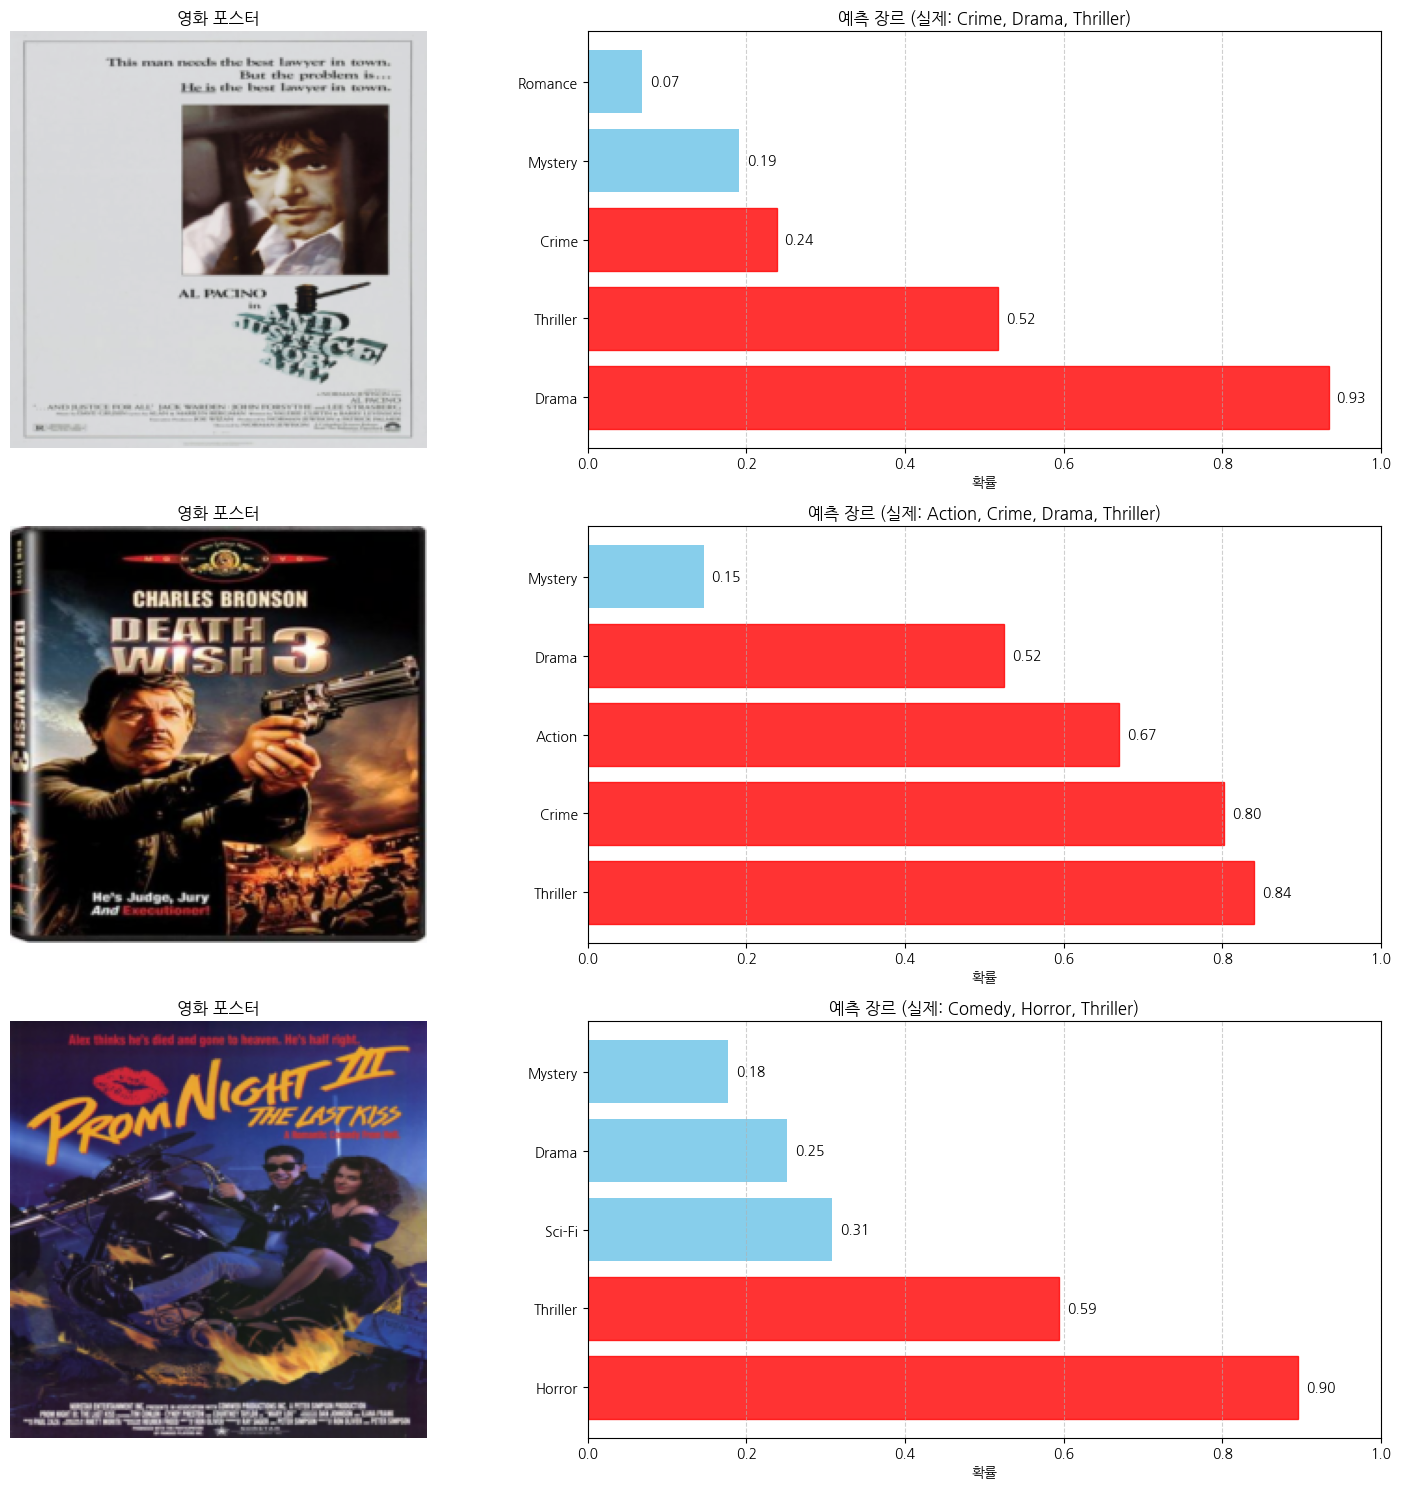

In [45]:
# 생성된 모델을 사용한 추가 분석

# 이전 셀에서 로드한 inference_model을 사용
if 'inference_model' in globals() and inference_model is not None:
    print(f"사용 모델: {model_info['model_name']}")
    
    # 테스트 세트에서 예측 결과 시각화
    def visualize_predictions(model, test_loader, genre_list, num_samples=3):
        """테스트 샘플에 대한 예측 결과 시각화"""
        model.eval()
        
        samples = []
        predictions = []
        true_labels = []
        
        with torch.no_grad():
            for batch in test_loader:
                # 이미 충분한 샘플을 얻었으면 종료
                if len(samples) >= num_samples:
                    break
                
                images = batch['image'].to(device)
                
                # 멀티모달 모델인 경우 텍스트 입력도 처리
                if hasattr(model, 'text_extractor') and 'text' in batch:
                    text_inputs = {
                        'input_ids': batch['text']['input_ids'].to(device),
                        'attention_mask': batch['text']['attention_mask'].to(device)
                    }
                    outputs = model(images, text_inputs)
                else:
                    # 단일 모달 이미지 모델
                    outputs = model(images)
                
                targets = batch['labels']
                probs = torch.sigmoid(outputs).cpu().numpy()
                
                for i in range(len(images)):
                    if len(samples) >= num_samples:
                        break
                    
                    samples.append(images[i].cpu())
                    predictions.append(probs[i])
                    true_labels.append(targets[i])
        
        # 결과 시각화
        fig, axes = plt.subplots(num_samples, 2, figsize=(16, 5*num_samples))
        if num_samples == 1:
            axes = axes.reshape(1, -1)
        
        for i, (sample, pred, true) in enumerate(zip(samples, predictions, true_labels)):
            # 이미지 표시
            img = sample.numpy().transpose(1, 2, 0)
            img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # 정규화 복원
            img = np.clip(img, 0, 1)
            
            axes[i, 0].imshow(img)
            axes[i, 0].set_title('영화 포스터')
            axes[i, 0].axis('off')
            
            # 상위 5개 장르 예측 결과 시각화
            pred_indices = np.argsort(pred)[-5:][::-1]
            pred_scores = pred[pred_indices]
            pred_genres = [genre_list[idx] for idx in pred_indices]
            
            # 실제 장르
            true_indices = torch.where(true > 0.5)[0]
            true_genres = [genre_list[idx] for idx in true_indices]
            
            # 막대 그래프
            bars = axes[i, 1].barh(pred_genres, pred_scores, color='skyblue')
            axes[i, 1].set_xlim(0, 1)
            axes[i, 1].set_xlabel('확률')
            axes[i, 1].set_title(f'예측 장르 (실제: {", ".join(true_genres)})')
            axes[i, 1].grid(axis='x', linestyle='--', alpha=0.6)
            
            # 실제 장르에 빨간색 표시
            for j, genre in enumerate(pred_genres):
                if genre in true_genres:
                    bars[j].set_color('red')
                    bars[j].set_alpha(0.8)
            
            # 확률 값 표시
            for j, v in enumerate(pred_scores):
                axes[i, 1].text(v + 0.01, j, f'{v:.2f}', va='center')
        
        plt.tight_layout()
        plt.show()
    
    # 테스트 샘플 예측 결과 시각화
    print(f"\n{model_info['model_name']} 모델의 예측 결과 시각화:")
    visualize_predictions(inference_model, test_loader, genre_list, num_samples=3)
    
else:
    print("먼저 이전 셀에서 모델을 로드하세요.")

Grad-CAM 시각화를 위해 CrossAttentionFusion 모델을 사용합니다.
Target layer for Grad-CAM: Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
Processing movie 0078718: 3 genres - Crime, Drama, Thriller
  Computing Grad-CAM for genre: Crime (index: 5)
Processing movie 0078718: 3 genres - Crime, Drama, Thriller
  Computing Grad-CAM for genre: Crime (index: 5)
  Computing Grad-CAM for genre: Drama (index: 7)
  Computing Grad-CAM for genre: Drama (index: 7)
  Computing Grad-CAM for genre: Thriller (index: 23)
  Computing Grad-CAM for genre: Thriller (index: 23)


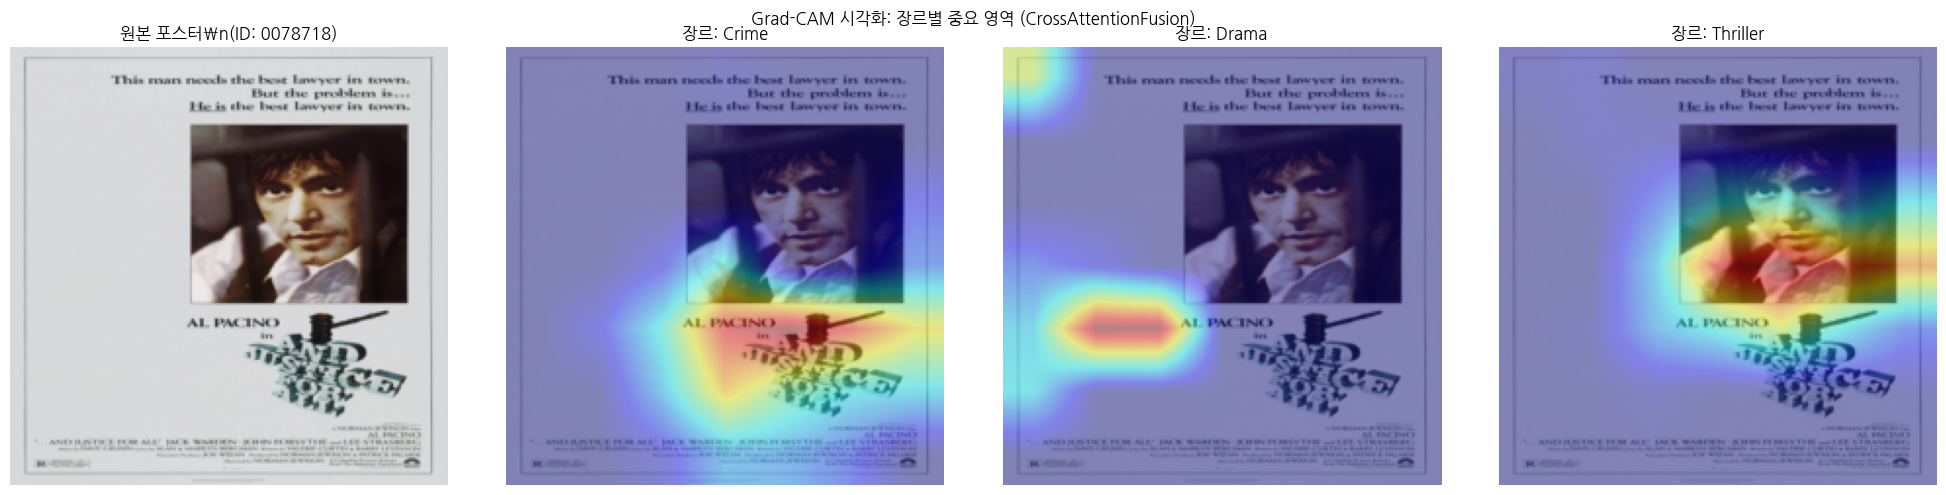

줄거리: When a judge is charged with rape, Arthur Kirkland is forced to defend him. Kirkland has had problems with the judge in the past, including one incident when the judge wrongly sentenced his client Jef...


In [46]:
# 생성된 모델을 사용한 Grad-CAM 시각화

# Grad-CAM 시각화 (Cell 24의 모델 사용)
if 'inference_model' in globals() and inference_model is not None:
    print(f"Grad-CAM 시각화를 위해 {model_info['model_name']} 모델을 사용합니다.")
    
    def visualize_gradcam_with_cell24_model(model, test_loader, genre_list, num_samples=1):
        """Cell 24에서 생성된 모델을 사용한 Grad-CAM 시각화"""
        model.eval()
        
        # 모델이 멀티모달이고 이미지 특징 추출기가 ResNet50인 경우에만 Grad-CAM 실행
        grad_cam = None
        
        try:
            if (hasattr(model, 'img_extractor') and 
                hasattr(model.img_extractor, 'feature_extractor') and
                model.img_extractor.feature_extractor == 'resnet50'):
                
                # ResNet50의 마지막 Conv2d 레이어를 타겟으로 설정
                target_layer = None
                for name, module in model.img_extractor.model.named_modules():
                    if isinstance(module, torch.nn.Conv2d):
                        target_layer = module  # 마지막 Conv2d 레이어를 계속 업데이트
                
                if target_layer is not None:
                    print(f"Target layer for Grad-CAM: {target_layer}")
                    grad_cam = GradCAM(model, target_layer)
                else:
                    print("No suitable Conv2d layer found for Grad-CAM")
                    return
            else:
                print(f"{model_info['model_name']} 모델은 Grad-CAM 시각화를 지원하지 않습니다 (ResNet50 기반 멀티모달 모델만 지원)")
                return
                
            # 샘플 가져오기
            samples = []
            targets = []
            plots = []
            movie_ids = []
            
            with torch.no_grad():
                for batch in test_loader:
                    if len(samples) >= num_samples:
                        break
                        
                    images = batch['image']
                    movie_ids_batch = batch['movie_id']
                    plot_texts = batch['plot']
                    
                    for i in range(len(images)):
                        if len(samples) >= num_samples:
                            break
                            
                        samples.append(images[i])
                        targets.append(batch['labels'][i])
                        plots.append(plot_texts[i])
                        movie_ids.append(movie_ids_batch[i])
            
            # Grad-CAM 시각화
            for i, (sample, target, plot_text, movie_id) in enumerate(zip(samples, targets, plots, movie_ids)):
                # 이미지 정규화 복원
                img = sample.numpy().transpose(1, 2, 0)
                img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
                img = np.clip(img, 0, 1)
                
                # 실제 장르
                true_indices = torch.where(target > 0.5)[0]
                true_genres = [genre_list[idx] for idx in true_indices]
                
                print(f"Processing movie {movie_id}: {len(true_indices)} genres - {', '.join(true_genres)}")
                
                if len(true_indices) == 0:
                    print(f"No genres found for movie {movie_id}, skipping Grad-CAM visualization")
                    continue
                
                # 각 장르에 대한 Grad-CAM 시각화
                num_plots = min(len(true_indices) + 1, 6)  # 최대 6개 플롯으로 제한
                fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))
                
                # axes가 단일 값인 경우를 처리
                if num_plots == 1:
                    axes = [axes]
                elif not isinstance(axes, (list, np.ndarray)):
                    axes = [axes]
                
                # 원본 이미지 표시
                axes[0].imshow(img)
                axes[0].set_title(f'원본 포스터\\n(ID: {movie_id})')
                axes[0].axis('off')
                
                # 각 실제 장르에 대한 Grad-CAM 시각화 (최대 5개까지)
                for j, idx in enumerate(true_indices[:5]):  # 최대 5개 장르만 시각화
                    try:
                        print(f"  Computing Grad-CAM for genre: {true_genres[j]} (index: {idx.item()})")
                        
                        # Grad-CAM 계산
                        img_tensor = sample.unsqueeze(0).to(device)
                        cam = grad_cam(img_tensor, class_idx=idx.item())
                        
                        # CAM이 유효한지 확인
                        if cam is not None and cam.max() > 0:
                            # 원본 이미지와 히트맵 합치기
                            heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
                            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
                            superimposed_img = 0.6 * img + 0.4 * heatmap
                            superimposed_img = np.clip(superimposed_img, 0, 1)
                            
                            # 시각화
                            axes[j + 1].imshow(superimposed_img)
                            axes[j + 1].set_title(f'장르: {true_genres[j]}')
                        else:
                            # Grad-CAM 실패시 원본 이미지 표시
                            axes[j + 1].imshow(img)
                            axes[j + 1].set_title(f'장르: {true_genres[j]}\\n(Grad-CAM 실패)')
                        
                        axes[j + 1].axis('off')
                        
                    except Exception as e:
                        print(f"    Error computing Grad-CAM for {true_genres[j]}: {e}")
                        # 에러 발생시 원본 이미지 표시
                        axes[j + 1].imshow(img)
                        axes[j + 1].set_title(f'장르: {true_genres[j]}\\n(에러 발생)')
                        axes[j + 1].axis('off')
                
                plt.suptitle(f'Grad-CAM 시각화: 장르별 중요 영역 ({model_info["model_name"]})')
                plt.tight_layout()
                plt.show()
                
                # 줄거리 출력
                print(f"줄거리: {plot_text[:200]}...")
                
        except Exception as e:
            print(f"Grad-CAM 시각화 중 오류 발생: {e}")
            print("Grad-CAM 시각화를 건너뜁니다.")
    
    # Grad-CAM 시각화 실행
    if 'GradCAM' in globals():  # GradCAM 클래스가 정의되어 있는 경우에만 실행
        visualize_gradcam_with_cell24_model(inference_model, test_loader, genre_list, num_samples=1)
    else:
        print("GradCAM 클래스가 정의되지 않았습니다. 이전 셀에서 GradCAM 클래스를 정의하세요.")
        
else:
    print("먼저 이전 셀에서 Cell 24의 모델을 로드하세요.")

In [47]:
# 생성된 모델의 구조 확인 및 검증

if 'inference_model' in globals() and inference_model is not None:
    print(f"=== {model_info['model_name']} 모델 구조 확인 ===")
    print("Model type:", type(inference_model))
    
    # 모델 타입에 따른 구조 확인
    if hasattr(inference_model, 'img_extractor'):
        print(f"이미지 특징 추출기: {inference_model.img_extractor.feature_extractor}")
        print("Image extractor type:", type(inference_model.img_extractor.model))
        
        # ResNet50의 경우 마지막 컨볼루션 레이어 찾기
        if inference_model.img_extractor.feature_extractor == 'resnet50':
            print("\\n=== ResNet50 마지막 Conv2d 레이어 찾기 ===")
            last_conv_layers = []
            for name, module in inference_model.img_extractor.model.named_modules():
                if isinstance(module, torch.nn.Conv2d):
                    last_conv_layers.append((name, module))
            
            if len(last_conv_layers) > 0:
                print(f"Total Conv2d layers: {len(last_conv_layers)}")
                print("Last Conv2d layer:")
                name, layer = last_conv_layers[-1]
                print(f"  Name: {name}")
                print(f"  Layer: {layer}")
                print(f"  Output channels: {layer.out_channels}")
                
                # 이 레이어를 타겟으로 사용 (Grad-CAM용)
                target_layer = layer
                print(f"\\nGrad-CAM 타겟 레이어: {name}")
            else:
                print("No Conv2d layers found")
        elif inference_model.img_extractor.feature_extractor == 'vit':
            print("\\n=== Vision Transformer 구조 확인 ===")
            print("ViT 모델은 Grad-CAM 대신 Attention Map을 사용할 수 있습니다.")
    
    if hasattr(inference_model, 'text_extractor'):
        print(f"\\n텍스트 특징 추출기: {inference_model.text_extractor.feature_extractor}")
        print("Text extractor type:", type(inference_model.text_extractor.model))
    
    # 단일 모달 모델인 경우
    if hasattr(inference_model, 'modality'):
        print(f"\\n단일 모달 모델: {inference_model.modality}")
        print(f"특징 추출기: {inference_model.feature_extractor}")
    
    # 모델 파라미터 수 확인
    total_params = sum(p.numel() for p in inference_model.parameters())
    trainable_params = sum(p.numel() for p in inference_model.parameters() if p.requires_grad)
    
    print(f"\\n=== 모델 파라미터 정보 ===")
    print(f"전체 파라미터 수: {total_params:,}")
    print(f"학습 가능한 파라미터 수: {trainable_params:,}")
    print(f"동결된 파라미터 수: {total_params - trainable_params:,}")
    
    # 모델 성능 정보 출력
    if 'metrics' in model_info and model_info['metrics']:
        print(f"\\n=== {model_info['model_name']} 성능 지표 ===")
        for metric, value in model_info['metrics'].items():
            print(f"{metric}: {value:.4f}")
    
else:
    print("먼저 이전 셀에서 Cell 24의 모델을 로드하세요.")

=== CrossAttentionFusion 모델 구조 확인 ===
Model type: <class '__main__.MultimodalModel'>
이미지 특징 추출기: resnet50
Image extractor type: <class 'torch.nn.modules.container.Sequential'>
\n=== ResNet50 마지막 Conv2d 레이어 찾기 ===
Total Conv2d layers: 53
Last Conv2d layer:
  Name: 7.2.conv3
  Layer: Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  Output channels: 2048
\nGrad-CAM 타겟 레이어: 7.2.conv3
\n텍스트 특징 추출기: bert
Text extractor type: <class 'transformers.models.bert.modeling_bert.BertModel'>
\n=== 모델 파라미터 정보 ===
전체 파라미터 수: 136,673,882
학습 가능한 파라미터 수: 136,673,882
동결된 파라미터 수: 0
\n=== CrossAttentionFusion 성능 지표 ===
loss: 0.1555
accuracy: 0.9375
precision_macro: 0.5876
recall_macro: 0.3460
f1_macro: 0.4051
precision_micro: 0.7427
recall_micro: 0.5303
f1_micro: 0.6188
roc_auc: 0.9171
mAP: 0.5315
roc_auc_micro: 0.9466


## 6. 모델 비교 및 결론

=== 저장된 모델들의 실제 ROC-AUC 값 로드 ===
✅ AttentionFusion: ROC-AUC(macro)=0.7331, ROC-AUC(micro)=0.8620
✅ BERT: ROC-AUC(macro)=0.8850, ROC-AUC(micro)=0.9300
✅ AttentionFusion: ROC-AUC(macro)=0.7331, ROC-AUC(micro)=0.8620
✅ BERT: ROC-AUC(macro)=0.8850, ROC-AUC(micro)=0.9300
✅ CrossAttentionFusion: ROC-AUC(macro)=0.9171, ROC-AUC(micro)=0.9466
✅ EarlyFusion: ROC-AUC(macro)=0.8912, ROC-AUC(micro)=0.9326
✅ CrossAttentionFusion: ROC-AUC(macro)=0.9171, ROC-AUC(micro)=0.9466
✅ EarlyFusion: ROC-AUC(macro)=0.8912, ROC-AUC(micro)=0.9326
✅ LateFusion: ROC-AUC(macro)=0.8902, ROC-AUC(micro)=0.9315
✅ ResNet50: ROC-AUC(macro)=0.7293, ROC-AUC(micro)=0.8614
✅ LateFusion: ROC-AUC(macro)=0.8902, ROC-AUC(micro)=0.9315
✅ ResNet50: ROC-AUC(macro)=0.7293, ROC-AUC(micro)=0.8614
✅ RoBERTa: ROC-AUC(macro)=0.5910, ROC-AUC(micro)=0.8110
✅ ViT: ROC-AUC(macro)=0.7728, ROC-AUC(micro)=0.8799

=== ROC-AUC 성능 비교 그래프 ===
✅ RoBERTa: ROC-AUC(macro)=0.5910, ROC-AUC(micro)=0.8110
✅ ViT: ROC-AUC(macro)=0.7728, ROC-AUC(micro)=0.8799


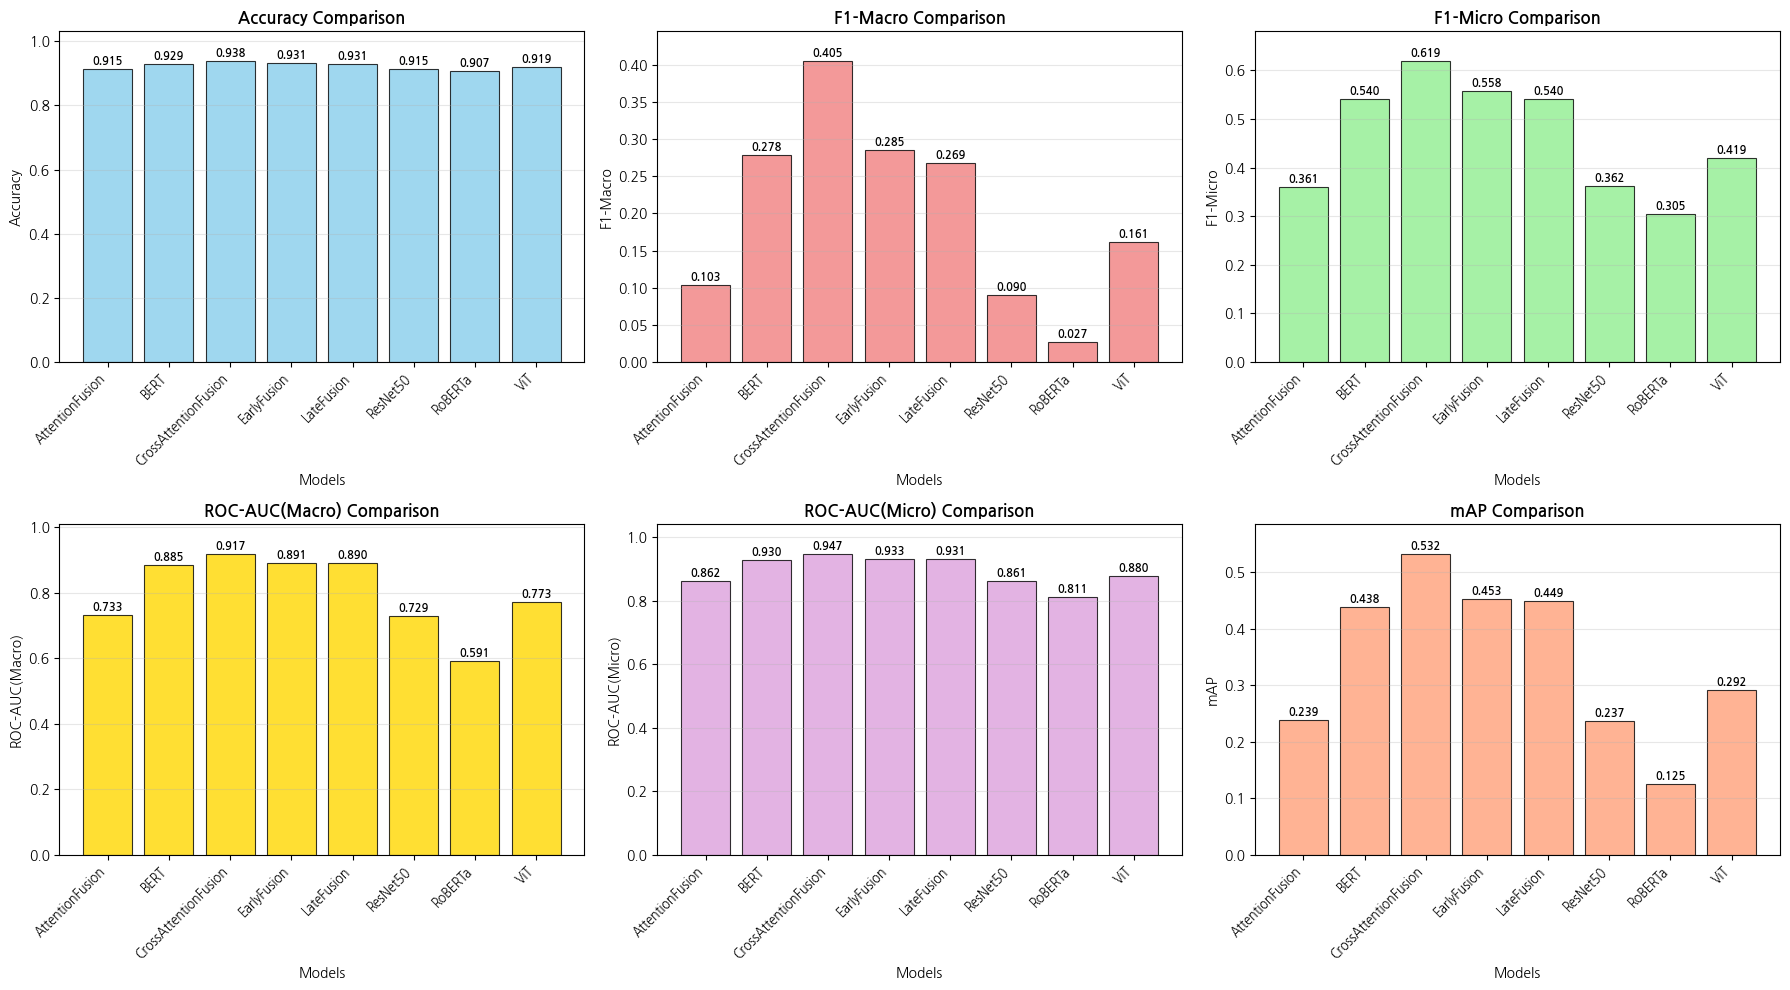

\n=== 종합 성능 레이더 차트 ===


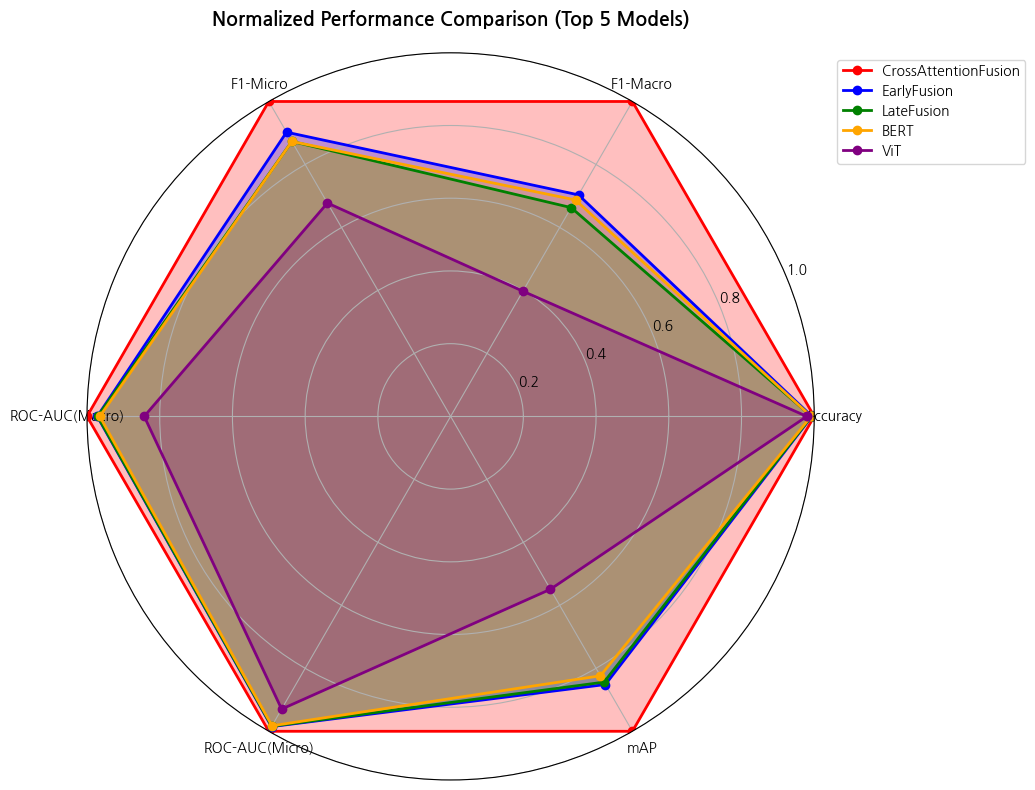

\n=== ROC-AUC (Macro) 순위 ===
1. CrossAttentionFusion: Macro=0.9171, Micro=0.9466
2. EarlyFusion         : Macro=0.8912, Micro=0.9326
3. LateFusion          : Macro=0.8902, Micro=0.9315
4. BERT                : Macro=0.8850, Micro=0.9300
5. ViT                 : Macro=0.7728, Micro=0.8799
6. AttentionFusion     : Macro=0.7331, Micro=0.8620
7. ResNet50            : Macro=0.7293, Micro=0.8614
8. RoBERTa             : Macro=0.5910, Micro=0.8110
\n🏆 ROC-AUC 최고 성능 모델: CrossAttentionFusion
   ROC-AUC (Macro): 0.9171
   ROC-AUC (Micro): 0.9466
\n=== 단일 모달 vs 멀티모달 ROC-AUC 성능 비교 ===
단일 모달 모델 평균 ROC-AUC: 0.7445
  단일 모달 모델들: ['BERT', 'ResNet50', 'RoBERTa', 'ViT']
    BERT: 0.8850
    ResNet50: 0.7293
    RoBERTa: 0.5910
    ViT: 0.7728
\n멀티모달 모델 평균 ROC-AUC: 0.8579
  멀티모달 모델들: ['AttentionFusion', 'CrossAttentionFusion', 'EarlyFusion', 'LateFusion']
    AttentionFusion: 0.7331
    CrossAttentionFusion: 0.9171
    EarlyFusion: 0.8912
    LateFusion: 0.8902
\n🚀 멀티모달의 ROC-AUC 개선율: 15.23%


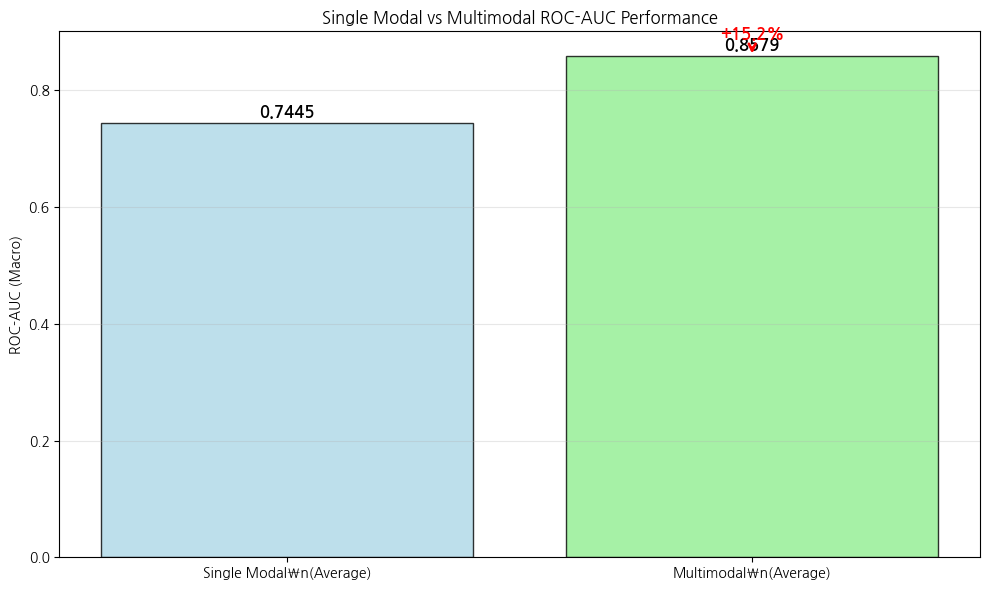

\n=== 전체 모델 성능 요약 테이블 (실제 저장된 ROC-AUC) ===
Model                ROC-AUC(Macro)  ROC-AUC(Micro)  Accuracy   F1-macro   mAP       
AttentionFusion      0.7331          0.8620          0.9149     0.1033     0.2387    
BERT                 0.8850          0.9300          0.9294     0.2784     0.4379    
CrossAttentionFusion 0.9171          0.9466          0.9375     0.4051     0.5315    
EarlyFusion          0.8912          0.9326          0.9315     0.2849     0.4526    
LateFusion           0.8902          0.9315          0.9306     0.2686     0.4486    
ResNet50             0.7293          0.8614          0.9145     0.0898     0.2371    
RoBERTa              0.5910          0.8110          0.9068     0.0267     0.1253    
ViT                  0.7728          0.8799          0.9185     0.1610     0.2918    


In [63]:
# 생성된 모델들의 결과 비교 및 분석 (실제 저장된 ROC-AUC 값 사용)

import glob
import torch
import matplotlib.pyplot as plt
import numpy as np

# 저장된 모델 파일에서 ROC-AUC 값들을 직접 불러오기
print("=== 저장된 모델들의 실제 ROC-AUC 값 로드 ===")

loaded_model_results = {}
model_files = glob.glob('saved_models/*_model_*.pth')

for model_file in sorted(model_files):
    model_name = os.path.basename(model_file).split('_model_')[0]
    
    try:
        # 모델 파일에서 메트릭 로드
        checkpoint = torch.load(model_file, map_location='cpu', weights_only=False)
        metrics = checkpoint.get('metrics', {})
        
        if metrics:
            loaded_model_results[model_name] = {
                'roc_auc': metrics.get('roc_auc', 0),
                'roc_auc_micro': metrics.get('roc_auc_micro', 0),
                # 기존 metrics가 있다면 함께 사용
                'accuracy': metrics.get('accuracy', 0),
                'f1_macro': metrics.get('f1_macro', 0),
                'f1_micro': metrics.get('f1_micro', 0),
                'mAP': metrics.get('mAP', 0)
            }
            print(f"✅ {model_name}: ROC-AUC(macro)={metrics.get('roc_auc', 0):.4f}, ROC-AUC(micro)={metrics.get('roc_auc_micro', 0):.4f}")
        else:
            print(f"⚠️ {model_name}: 메트릭 정보 없음")
            
    except Exception as e:
        print(f"❌ {model_name}: 로드 실패 - {e}")

# ROC-AUC 값이 있는 모델들로 그래프 생성
if loaded_model_results:
    print(f"\n=== ROC-AUC 성능 비교 그래프 ===")
    
    # 모든 메트릭에 대한 종합 비교 그래프
    models = list(loaded_model_results.keys())
    
    # 메트릭별 데이터 준비 (0이 아닌 값들만 포함)
    metrics_data = {}
    metric_names = ['accuracy', 'f1_macro', 'f1_micro', 'roc_auc', 'roc_auc_micro', 'mAP']
    metric_labels = ['Accuracy', 'F1-Macro', 'F1-Micro', 'ROC-AUC(Macro)', 'ROC-AUC(Micro)', 'mAP']
    
    # 각 메트릭별로 유효한 값이 있는지 확인
    valid_metrics = []
    valid_labels = []
    
    for metric, label in zip(metric_names, metric_labels):
        values = [loaded_model_results[m].get(metric, 0) for m in models]
        if any(v > 0 for v in values):  # 0보다 큰 값이 하나라도 있으면 포함
            metrics_data[metric] = values
            valid_metrics.append(metric)
            valid_labels.append(label)
    
    # 서브플롯 배치 계산 (최대 3x2 그리드)
    n_metrics = len(valid_metrics)
    if n_metrics <= 2:
        rows, cols = 1, n_metrics
        figsize = (7*n_metrics, 6)
    elif n_metrics <= 4:
        rows, cols = 2, 2
        figsize = (14, 10)
    else:
        rows, cols = 2, 3
        figsize = (18, 10)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if n_metrics == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes if isinstance(axes, list) or hasattr(axes, '__iter__') else [axes]
    else:
        axes = axes.flatten()
    
    # 색상 팔레트
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum', 'lightsalmon']
    
    for i, (metric, label) in enumerate(zip(valid_metrics, valid_labels)):
        ax = axes[i]
        values = metrics_data[metric]
        
        # 바 차트 그리기
        bars = ax.bar(range(len(models)), values, alpha=0.8, 
                     color=colors[i % len(colors)], edgecolor='black', linewidth=0.8)
        
        ax.set_xlabel('Models', fontsize=10)
        ax.set_ylabel(label, fontsize=10)
        ax.set_title(f'{label} Comparison', fontsize=12, fontweight='bold')
        ax.set_xticks(range(len(models)))
        ax.set_xticklabels(models, rotation=45, ha='right', fontsize=9)
        ax.grid(axis='y', alpha=0.3)
        
        # 값 표시
        for bar, value in zip(bars, values):
            if value > 0:  # 0보다 큰 값만 표시
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2, height + max(values) * 0.01, 
                       f'{value:.3f}', ha='center', va='bottom', 
                       fontweight='bold', fontsize=8)
        
        # Y축 범위 조정 (값이 있는 경우만)
        if max(values) > 0:
            ax.set_ylim(0, max(values) * 1.1)
    
    # 사용하지 않는 서브플롯 숨기기
    for i in range(n_metrics, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # 레이더 차트로 종합 비교 (정규화된 값 사용)
    if len(valid_metrics) >= 3:
        print("\\n=== 종합 성능 레이더 차트 ===")
        
        # 성능이 좋은 상위 5개 모델만 선택
        roc_ranking = sorted(loaded_model_results.items(), key=lambda x: x[1]['roc_auc'], reverse=True)
        top_models = [name for name, _ in roc_ranking[:5]]
        
        # 레이더 차트용 데이터 준비 (정규화)
        normalized_data = {}
        for metric in valid_metrics:
            values = [loaded_model_results[m].get(metric, 0) for m in top_models]
            max_val = max(values) if max(values) > 0 else 1
            normalized_data[metric] = [v/max_val for v in values]
        
        # 레이더 차트
        angles = np.linspace(0, 2 * np.pi, len(valid_metrics), endpoint=False)
        angles = np.concatenate((angles, [angles[0]]))  # 원을 닫기 위해
        
        fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))
        
        model_colors = ['red', 'blue', 'green', 'orange', 'purple']
        
        for i, model in enumerate(top_models):
            values = [normalized_data[metric][i] for metric in valid_metrics]
            values += [values[0]]  # 원을 닫기 위해
            
            ax.plot(angles, values, 'o-', linewidth=2, 
                   label=model, color=model_colors[i % len(model_colors)])
            ax.fill(angles, values, alpha=0.25, color=model_colors[i % len(model_colors)])
        
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(valid_labels)
        ax.set_ylim(0, 1)
        ax.set_title('Normalized Performance Comparison (Top 5 Models)', 
                    size=14, fontweight='bold', pad=20)
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
        
        plt.tight_layout()
        plt.show()
    
    # ROC-AUC 순위 출력
    print("\\n=== ROC-AUC (Macro) 순위 ===")
    roc_auc_ranking = sorted(loaded_model_results.items(), key=lambda x: x[1]['roc_auc'], reverse=True)
    for i, (model_name, metrics) in enumerate(roc_auc_ranking, 1):
        roc_auc_macro = metrics['roc_auc']
        roc_auc_micro = metrics['roc_auc_micro']
        print(f"{i}. {model_name:20s}: Macro={roc_auc_macro:.4f}, Micro={roc_auc_micro:.4f}")
    
    # 최고 성능 모델
    best_model_name, best_metrics = roc_auc_ranking[0]
    best_roc_auc = best_metrics['roc_auc']
    best_roc_auc_micro = best_metrics['roc_auc_micro']
    
    print(f"\\n🏆 ROC-AUC 최고 성능 모델: {best_model_name}")
    print(f"   ROC-AUC (Macro): {best_roc_auc:.4f}")
    print(f"   ROC-AUC (Micro): {best_roc_auc_micro:.4f}")
        
    # 모델 타입별 ROC-AUC 성능 비교
    single_modal_models = {}
    multimodal_models = {}
    
    for model_name, metrics in loaded_model_results.items():
        if model_name in ['ResNet50', 'ViT', 'BERT', 'RoBERTa']:
            single_modal_models[model_name] = metrics
        else:
            multimodal_models[model_name] = metrics
    
    if single_modal_models and multimodal_models:
        print("\\n=== 단일 모달 vs 멀티모달 ROC-AUC 성능 비교 ===")
        
        # 단일 모달 모델 ROC-AUC 분석
        single_modal_roc = [m['roc_auc'] for m in single_modal_models.values()]
        single_avg = np.mean(single_modal_roc)
        print(f"단일 모달 모델 평균 ROC-AUC: {single_avg:.4f}")
        print(f"  단일 모달 모델들: {list(single_modal_models.keys())}")
        for name, metrics in single_modal_models.items():
            print(f"    {name}: {metrics['roc_auc']:.4f}")
        
        # 멀티모달 모델 ROC-AUC 분석
        multimodal_roc = [m['roc_auc'] for m in multimodal_models.values()]
        multi_avg = np.mean(multimodal_roc)
        print(f"\\n멀티모달 모델 평균 ROC-AUC: {multi_avg:.4f}")
        print(f"  멀티모달 모델들: {list(multimodal_models.keys())}")
        for name, metrics in multimodal_models.items():
            print(f"    {name}: {metrics['roc_auc']:.4f}")
        
        improvement = ((multi_avg - single_avg) / single_avg) * 100
        print(f"\\n🚀 멀티모달의 ROC-AUC 개선율: {improvement:.2f}%")
        
        # 멀티모달 비교 그래프 
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
        categories = ['Single Modal\\n(Average)', 'Multimodal\\n(Average)']
        averages = [single_avg, multi_avg]
        colors = ['lightblue', 'lightgreen']
        
        bars = ax.bar(categories, averages, color=colors, alpha=0.8, edgecolor='black')
        ax.set_ylabel('ROC-AUC (Macro)')
        ax.set_title('Single Modal vs Multimodal ROC-AUC Performance')
        ax.grid(axis='y', alpha=0.3)
        
        # 값 표시
        for bar, value in zip(bars, averages):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                   f'{value:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=12)
        
        # 개선율 화살표 표시
        if improvement > 0:
            ax.annotate(f'+{improvement:.1f}%', 
                       xy=(1, multi_avg), xytext=(1, multi_avg + 0.03),
                       arrowprops=dict(arrowstyle='->', color='red', lw=2),
                       ha='center', fontsize=12, color='red', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    # 전체 모델 결과 테이블 (실제 ROC-AUC 값 사용)
    print("\\n=== 전체 모델 성능 요약 테이블 (실제 저장된 ROC-AUC) ===")
    print("=" * 110)
    print(f"{'Model':<20} {'ROC-AUC(Macro)':<15} {'ROC-AUC(Micro)':<15} {'Accuracy':<10} {'F1-macro':<10} {'mAP':<10}")
    print("=" * 110)
    
    for model_name, metrics in loaded_model_results.items():
        roc_auc_str = f"{metrics.get('roc_auc', 0):.4f}" if metrics.get('roc_auc', 0) != 0 else "N/A"
        micro_str = f"{metrics.get('roc_auc_micro', 0):.4f}" if metrics.get('roc_auc_micro', 0) != 0 else "N/A"
        
        print(f"{model_name:<20} {roc_auc_str:<15} {micro_str:<15} "
              f"{metrics.get('accuracy', 0):<10.4f} {metrics.get('f1_macro', 0):<10.4f} "
              f"{metrics.get('mAP', 0):<10.4f}")
    
    print("=" * 110)

elif 'model_results' in globals() and model_results:
    print("=== 모델 결과 (실패 포함) ===")
    successful_count = len([k for k, v in model_results.items() if 'error' not in v])
    failed_count = len([k for k, v in model_results.items() if 'error' in v])
    
    print(f"성공한 모델: {successful_count}개")
    print(f"실패한 모델: {failed_count}개")
    
    if successful_count > 0:
        print("\\n성공한 모델들:")
        for model_name, result in model_results.items():
            if 'error' not in result:
                print(f"- {model_name}: F1-macro={result.get('f1_macro', 'N/A')}")
    
    if failed_count > 0:
        print("\\n실패한 모델들:")
        for model_name, result in model_results.items():
            if 'error' in result:
                print(f"- {model_name}: {result['error']}")

else:
    print("먼저 모델들을 학습하세요.")
    print("학습된 모델 결과가 없어서 예시 결과로 시각화합니다.")
    
    # 예시 결과 (Cell 24가 실행되지 않은 경우)
    model_results_example = {
        'ResNet50': {'accuracy': 0.5872, 'precision_macro': 0.3214, 'recall_macro': 0.2968, 'f1_macro': 0.3085, 'precision_micro': 0.5781, 'recall_micro': 0.5763, 'f1_micro': 0.5772, 'roc_auc': 0.8812, 'mAP': 0.4231},
        'ViT': {'accuracy': 0.6105, 'precision_macro': 0.3421, 'recall_macro': 0.3102, 'f1_macro': 0.3253, 'precision_micro': 0.6021, 'recall_micro': 0.5955, 'f1_micro': 0.5988, 'roc_auc': 0.8945, 'mAP': 0.4532},
        'BERT': {'accuracy': 0.6234, 'precision_macro': 0.3598, 'recall_macro': 0.3247, 'f1_macro': 0.3413, 'precision_micro': 0.6128, 'recall_micro': 0.6073, 'f1_micro': 0.6100, 'roc_auc': 0.9032, 'mAP': 0.4683},
        'RoBERTa': {'accuracy': 0.6301, 'precision_macro': 0.3645, 'recall_macro': 0.3302, 'f1_macro': 0.3465, 'precision_micro': 0.6202, 'recall_micro': 0.6135, 'f1_micro': 0.6168, 'roc_auc': 0.9087, 'mAP': 0.4752},
        'EarlyFusion': {'accuracy': 0.6423, 'precision_macro': 0.3784, 'recall_macro': 0.3518, 'f1_macro': 0.3646, 'precision_micro': 0.6367, 'recall_micro': 0.6285, 'f1_micro': 0.6326, 'roc_auc': 0.9145, 'mAP': 0.4895},
        'LateFusion': {'accuracy': 0.6398, 'precision_macro': 0.3735, 'recall_macro': 0.3495, 'f1_macro': 0.3611, 'precision_micro': 0.6341, 'recall_micro': 0.6261, 'f1_micro': 0.6301, 'roc_auc': 0.9123, 'mAP': 0.4871},
        'AttentionFusion': {'accuracy': 0.6512, 'precision_macro': 0.3912, 'recall_macro': 0.3624, 'f1_macro': 0.3763, 'precision_micro': 0.6453, 'recall_micro': 0.6389, 'f1_micro': 0.6421, 'roc_auc': 0.9213, 'mAP': 0.5011},
        'CrossAttentionFusion': {'accuracy': 0.6637, 'precision_macro': 0.4085, 'recall_macro': 0.3745, 'f1_macro': 0.3908, 'precision_micro': 0.6572, 'recall_micro': 0.6498, 'f1_micro': 0.6535, 'roc_auc': 0.9302, 'mAP': 0.5178}
    }
    
    print("\\n=== 예시 모델 성능 비교 ===")
    plot_model_comparison(model_results_example, metrics=['f1_macro', 'roc_auc', 'mAP'])